In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Running from the root makes things easy

In [2]:
%cd ../..

/home/kamen/Workspace/Coursework/year4/mlp/mlp-03


In [3]:
from src.datautils.sandia import SandiaDataProvider

# Setup data provider

In [4]:
train_batch_size = 16
val_batch_size = 8
test_batch_size = 4

train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='datasets/sandia/',
                                  img_size=28)
val_data = SandiaDataProvider(which_set='valid',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)

# Define models

In [29]:
import src
import importlib
importlib.reload(src.autoencoders)

<module 'src.autoencoders' from '/home/kamen/Workspace/Coursework/year4/mlp/mlp-03/src/autoencoders.py'>

In [97]:
from src.autoencoders import Conv2DAutoencoder, PCAAutoencoder, FeedforwardAutoencoder
from src.reasoning_agents import FFNReasoningAgent
from src.classifiers import PairwiseClassifier
from src.utiq import UTIQ

lr = 0.1
momentum = 0.5
use_cuda = torch.cuda.is_available()
latent_size = 50

pca_autoencoder = PCAAutoencoder(latent_size)
conv_autoencoder = Conv2DAutoencoder(latent_size)

hidden_sizes = [500, 400]
# Input is (28*28)
feedforward_autoencoder = FeedforwardAutoencoder(input_size=28*28, latent_size=latent_size, hidden_sizes=hidden_sizes)

if use_cuda:
    map(lambda x: x.cuda(), [pca_autoencoder, conv_autoencoder, feedforward_autoencoder])

# Train only autoencoder

# If PCA

In [103]:
# train_data.inputs is still num_ex x im_width x im_height x num_im
X = train_data.inputs.transpose(3, 0, 1, 2).reshape(-1, 28 * 28)
pca_autoencoder.train_encoding(X)

# If differentiable

In [98]:
log_interval = 50
def train_autoencoder_only_step(epoch, autoencoder, optimizer, losses):
    autoencoder.train()
    # Get new gen object at every epoch
    train_batch_size = 16
    train_loader = train_data.get_image_batch_iterator(train_batch_size)
    for batch_idx, (data, _) in enumerate(train_loader):
        # Set autoencoder target
        target = data
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        # Ignore latent representations
        output, _ = autoencoder(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if batch_idx % log_interval == 0:
            print('Train Epoch: {0} Loss: {1:.6f}'.format(epoch, loss.data[0]))

def train_autoencoder_only(autoencoder, epochs):
    losses = []
    optimizer = optim.SGD(autoencoder.parameters(), lr=lr, momentum=momentum)
    for epoch in range(1, epochs + 1):
        train_autoencoder_only_step(epoch, autoencoder, optimizer, losses)
    return losses

In [99]:
conv_losses = train_autoencoder_only(conv_autoencoder, 10)

Train Epoch: 1 Loss: 1.749693
Train Epoch: 1 Loss: 1.765815
Train Epoch: 1 Loss: 1.026676
Train Epoch: 1 Loss: 1.156063
Train Epoch: 1 Loss: 1.419697
Train Epoch: 1 Loss: 1.017375
Train Epoch: 1 Loss: 1.141654
Train Epoch: 1 Loss: 0.447614
Train Epoch: 1 Loss: 0.903833
Train Epoch: 1 Loss: 0.931499
Train Epoch: 1 Loss: 1.350077
Train Epoch: 1 Loss: 0.836728
Train Epoch: 1 Loss: 0.897958
Train Epoch: 1 Loss: 0.762400
Train Epoch: 2 Loss: 1.137056
Train Epoch: 2 Loss: 0.684927
Train Epoch: 2 Loss: 1.109375
Train Epoch: 2 Loss: 0.732038
Train Epoch: 2 Loss: 0.793440
Train Epoch: 2 Loss: 0.677198
Train Epoch: 2 Loss: 0.987077
Train Epoch: 2 Loss: 0.895090
Train Epoch: 2 Loss: 1.700091
Train Epoch: 2 Loss: 0.793563
Train Epoch: 2 Loss: 0.812908
Train Epoch: 2 Loss: 0.930771
Train Epoch: 2 Loss: 1.082582
Train Epoch: 2 Loss: 1.309530
Train Epoch: 3 Loss: 0.742513
Train Epoch: 3 Loss: 1.025155
Train Epoch: 3 Loss: 0.437143
Train Epoch: 3 Loss: 1.047599
Train Epoch: 3 Loss: 0.636053
Train Epoc

In [33]:
feedforward_losses = train_autoencoder_only(feedforward_autoencoder, 10)

Train Epoch: 1 Loss: 0.698426
Train Epoch: 1 Loss: 0.793065
Train Epoch: 1 Loss: 0.712728
Train Epoch: 1 Loss: 0.594057
Train Epoch: 1 Loss: 0.545962
Train Epoch: 1 Loss: 0.574647
Train Epoch: 1 Loss: 0.573532
Train Epoch: 1 Loss: 0.598062
Train Epoch: 1 Loss: 0.457370
Train Epoch: 1 Loss: 0.684587
Train Epoch: 1 Loss: 0.576166
Train Epoch: 1 Loss: 0.384847
Train Epoch: 1 Loss: 0.406627
Train Epoch: 1 Loss: 0.352784
Train Epoch: 2 Loss: 0.373588
Train Epoch: 2 Loss: 0.468945
Train Epoch: 2 Loss: 0.563810
Train Epoch: 2 Loss: 0.363080
Train Epoch: 2 Loss: 0.325819
Train Epoch: 2 Loss: 0.337747
Train Epoch: 2 Loss: 0.571010
Train Epoch: 2 Loss: 0.397601
Train Epoch: 2 Loss: 0.338864
Train Epoch: 2 Loss: 0.258413
Train Epoch: 2 Loss: 0.244629
Train Epoch: 2 Loss: 0.455061
Train Epoch: 2 Loss: 0.429182
Train Epoch: 2 Loss: 0.292719
Train Epoch: 3 Loss: 0.263008
Train Epoch: 3 Loss: 0.250328
Train Epoch: 3 Loss: 0.296029
Train Epoch: 3 Loss: 0.252385
Train Epoch: 3 Loss: 0.234942
Train Epoc

In [100]:
data, output = None, None
val_loader = val_data.get_image_batch_iterator(val_batch_size)
data, _ = next(val_loader)
# Set autoencoder target
target = data
if use_cuda:
    data, target = data.cuda(), target.cuda()
data, target = Variable(data), Variable(target)

In [104]:
# Ignore latent representations
pca_output, _ = pca_autoencoder(data)
conv_output, _ = conv_autoencoder(data)
feedforward_output, _ = feedforward_autoencoder(data)

In [105]:
data_np = data.squeeze().cpu().data.numpy()
pca_output_np = pca_output.squeeze().cpu().data.numpy()
conv_output_np = conv_output.squeeze().cpu().data.numpy()
feedforward_output_np = feedforward_output.squeeze().cpu().data.numpy()

In [106]:
from src.utils import show_grid_of_images
show_grid_of_images(np.concatenate([data_np, pca_output_np, conv_output_np, feedforward_output_np]), img_size=(val_batch_size, 1), grid_size=(4, val_batch_size), cmap='gray')

In [41]:
pca_autoencoder.set_frozen(True)
conv_autoencoder.set_frozen(True)
feedforward_autoencoder.set_frozen(True)

### Train rest of architecture

In [112]:
hidden_dim = 100
num_hidden_layers = 1
lr = 0.05
momentum = 0.1
latent_size = 50
train_batch_size = 64

feedforward_autoencoder = FeedforwardAutoencoder(input_size=28*28, latent_size=latent_size, hidden_sizes=hidden_sizes)
# conv_autoencoder = Conv2DAutoencoder(latent_size)

reasoning_agent = FFNReasoningAgent(latent_size, hidden_dim, num_hidden=num_hidden_layers)
# reasoning_agent = FFNReasoningAgent(latent_size)

# classifier = PairwiseClassifier(latent_size)

model = UTIQ(conv_autoencoder, reasoning_agent, None, use_classifier=False)
if use_cuda:
    model.cuda()

In [113]:
torch.manual_seed(123)

In [114]:
optimizer = optim.SGD([x for x in model.parameters() if x.requires_grad], lr=lr, momentum=momentum)

In [115]:
import src
import importlib
importlib.reload(src.utils)
importlib.reload(src.train_test)

<module 'src.train_test' from '/home/kamen/Workspace/Coursework/year4/mlp/mlp-03/src/train_test.py'>

In [116]:
from src.train_test import train, test
epochs = 600
result = train(model, optimizer, train_data, val_data, use_cuda, train_batch_size, epochs, epoch_patience=20)
best_acc_epoch_idx, model, train_losses, val_losses, train_accuracies, val_accuracies = result

Train: Epoch: 1 Loss: 0.083859 Accuracy 0.098361
Validation: Epoch: 1 Loss: 0.046943 Accuracy 0.142857
Train: Epoch: 2 Loss: 0.063413 Accuracy 0.153502
Validation: Epoch: 2 Loss: 0.050388 Accuracy 0.166667
Train: Epoch: 3 Loss: 0.070336 Accuracy 0.162444
Validation: Epoch: 3 Loss: 0.052985 Accuracy 0.214286
Train: Epoch: 4 Loss: 0.062621 Accuracy 0.192250
Validation: Epoch: 4 Loss: 0.034994 Accuracy 0.154762
Train: Epoch: 5 Loss: 0.063928 Accuracy 0.220566
Validation: Epoch: 5 Loss: 0.029596 Accuracy 0.119048
Train: Epoch: 6 Loss: 0.044799 Accuracy 0.190760
Validation: Epoch: 6 Loss: 0.045253 Accuracy 0.214286
Train: Epoch: 7 Loss: 0.055793 Accuracy 0.216095
Validation: Epoch: 7 Loss: 0.066012 Accuracy 0.321429
Train: Epoch: 8 Loss: 0.054403 Accuracy 0.260805
Validation: Epoch: 8 Loss: 0.062978 Accuracy 0.333333
Train: Epoch: 9 Loss: 0.054352 Accuracy 0.299553
Validation: Epoch: 9 Loss: 0.043993 Accuracy 0.285714
Train: Epoch: 10 Loss: 0.066665 Accuracy 0.326379
Validation: Epoch: 10 L

In [117]:
test(model, optimizer, test_data, use_cuda, test_batch_size)


Test set: Average loss: 69.8689, Accuracy: 33/84 (39%)



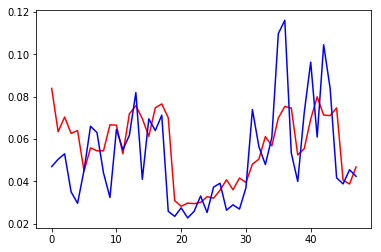

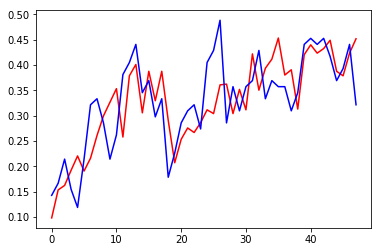

In [118]:
epoch_idxs = np.arange(len(train_losses))
plt.plot(epoch_idxs, train_losses, 'r')
plt.plot(epoch_idxs, val_losses, 'b')
plt.show()
plt.plot(epoch_idxs, train_accuracies, 'r')
plt.plot(epoch_idxs, val_accuracies, 'b')
plt.show()

In [90]:
from src.utils import make_vars

# val_batch_size = val_data.size()
val_batch_size = 8

val_loader = val_data.get_batch_iterator(val_batch_size, transpose_inputs=True, separate_inputs=True)

(q_vectors, a_vectors), labels = next(val_loader)
q_vectors, a_vectors, labels = make_vars([q_vectors, a_vectors, labels], ['float', 'float', 'long'], use_cuda=use_cuda)
logits, latent_prediction, decoded_q_vectors, decoded_a_vectors, latent_a_vectors = model(q_vectors, a_vectors)

In [91]:
targets = a_vectors

indices = torch.from_numpy(np.arange(val_batch_size)).long()
if use_cuda:
    indices = indices.cuda()
targets = targets[indices, labels.data].squeeze()

In [92]:
sq_err = (latent_a_vectors - latent_prediction) ** 2
tot_sq_err = sq_err.sum(2)
_, pred_var = torch.min(tot_sq_err, 1)

In [28]:
# When PCA
decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size)).squeeze().view(val_batch_size, 28, 28)

In [93]:
# When differentiable Conv AE
decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size, 1, 1)).squeeze()

In [77]:
# When differentiable Linear AE
decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size)).squeeze().view(val_batch_size, 28, 28)

### Show as part of matrix

In [94]:
import src
import importlib
importlib.reload(src.utils)
importlib.reload(src.train_test)
from src.utils import show_matrix

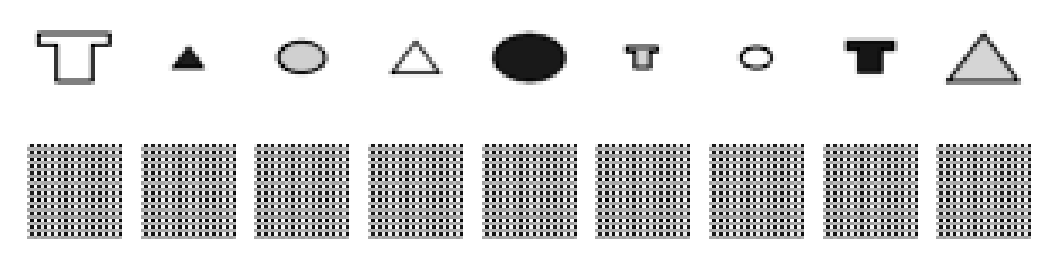

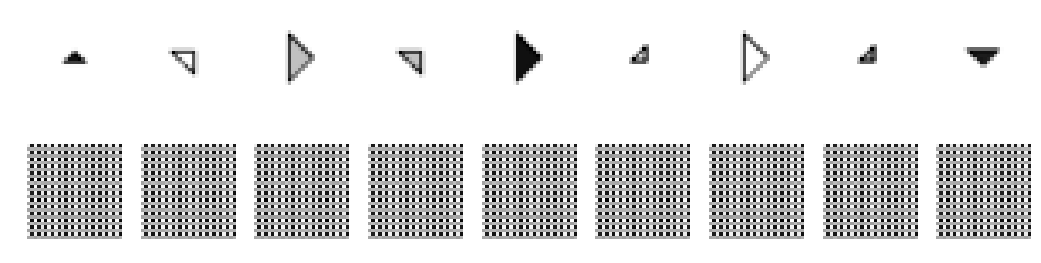

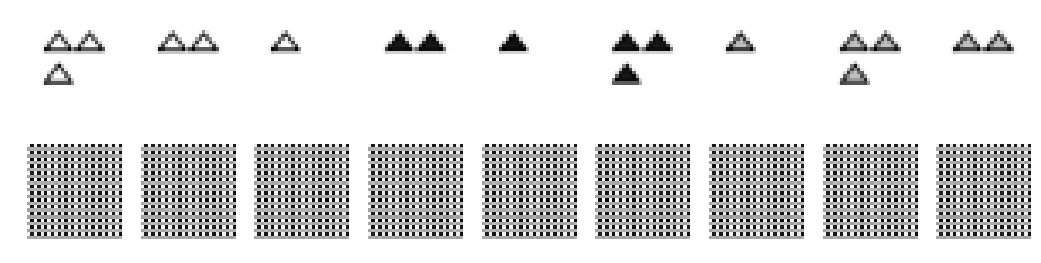

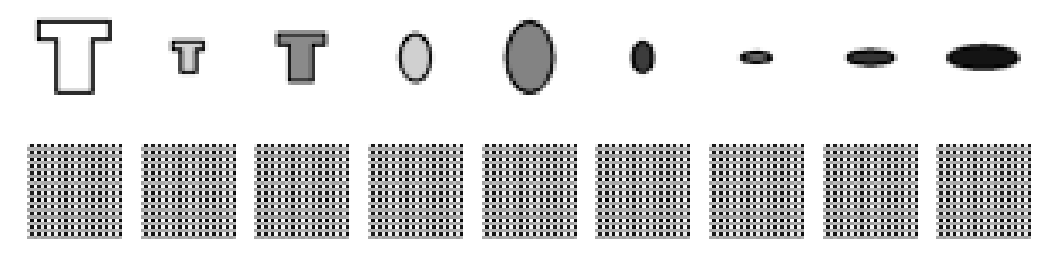

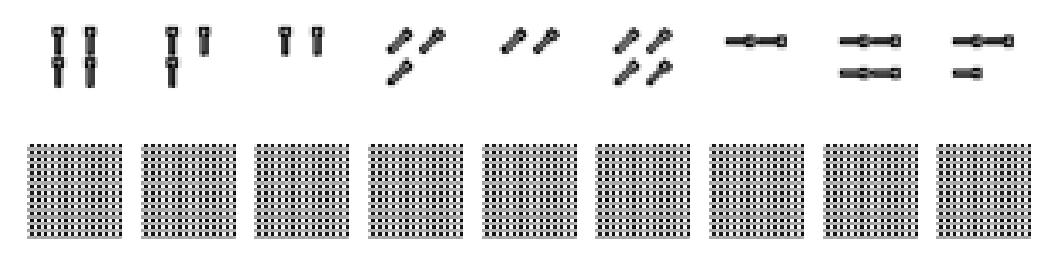

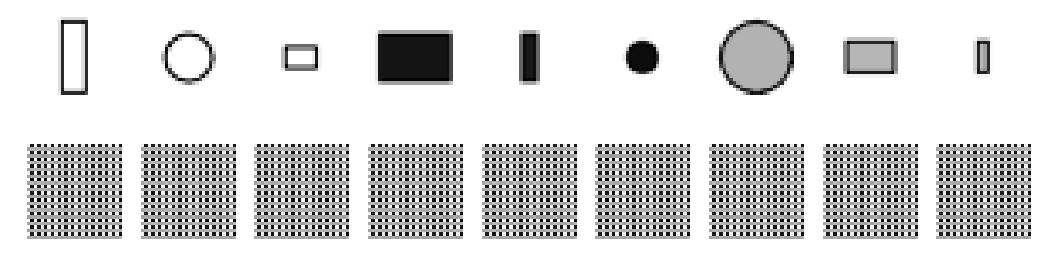

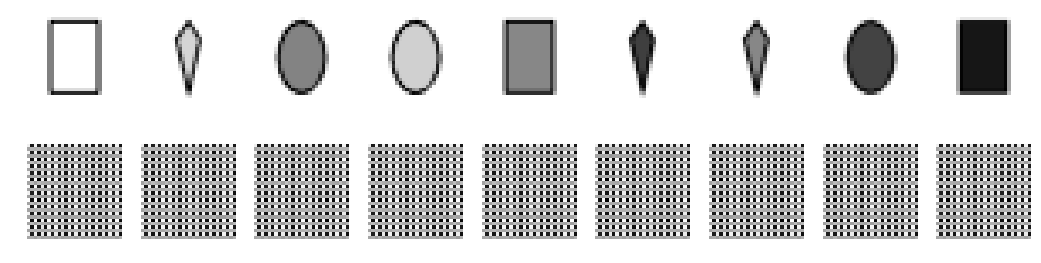

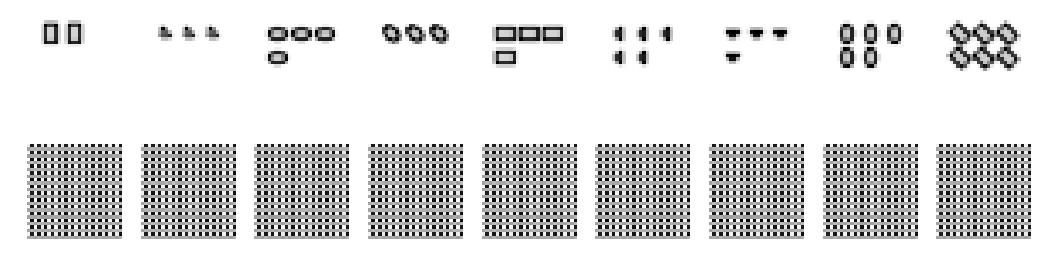

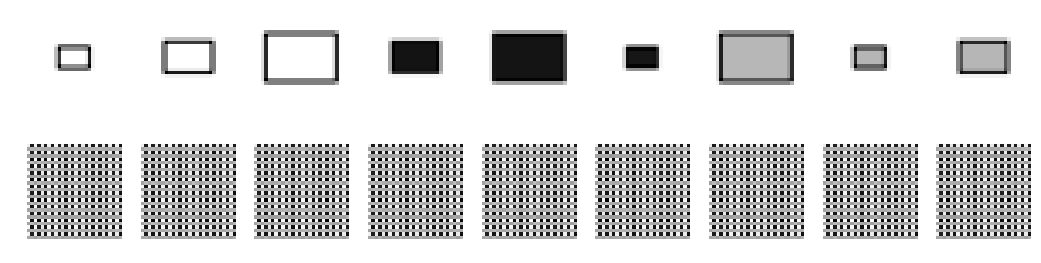

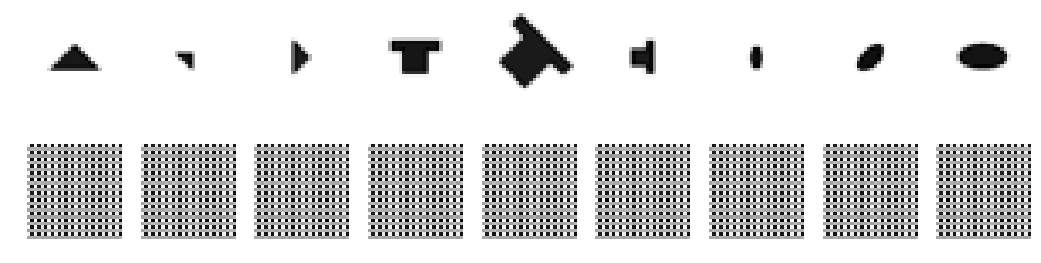

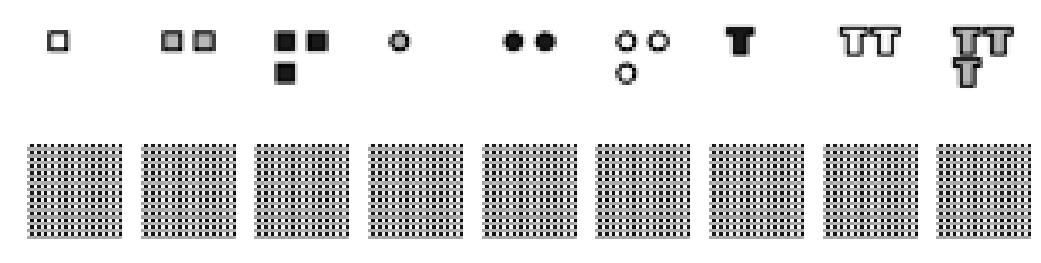

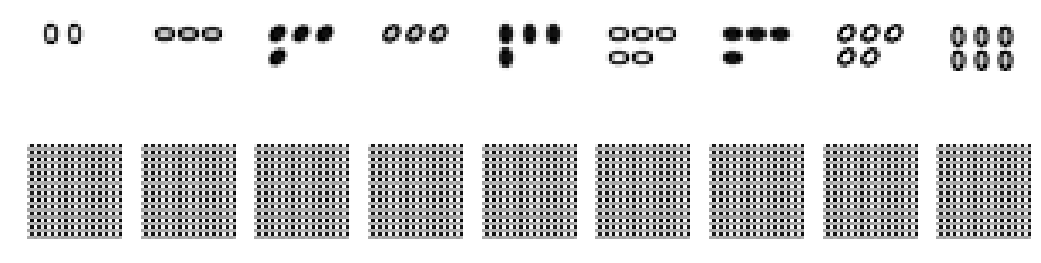

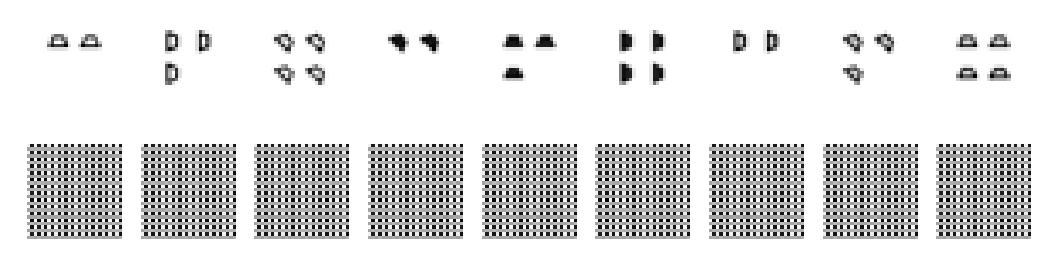

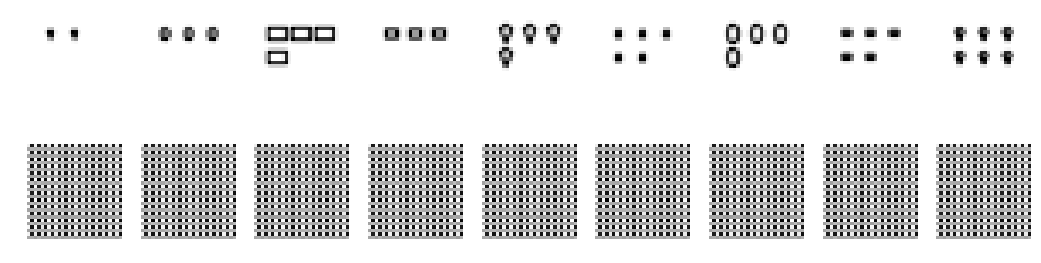

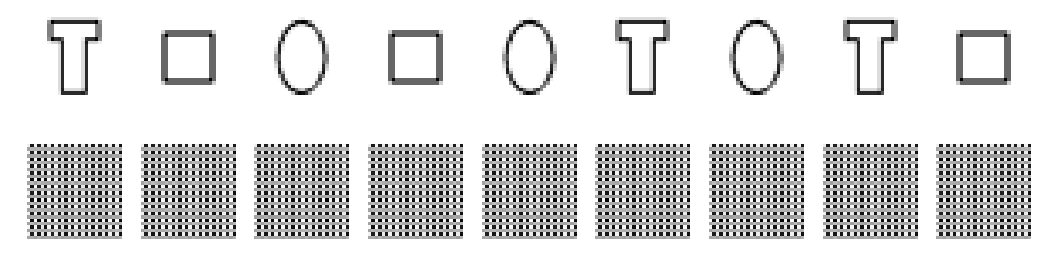

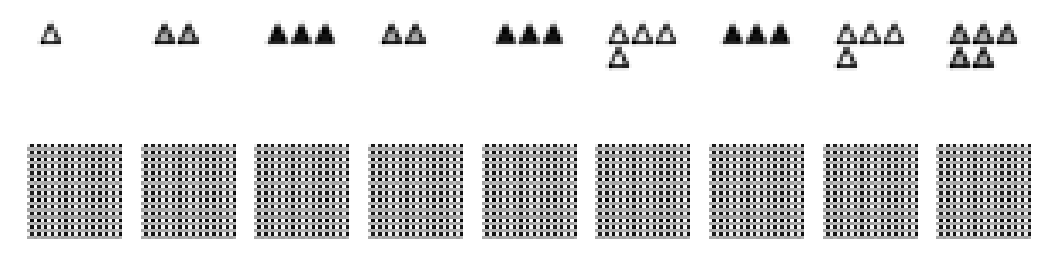

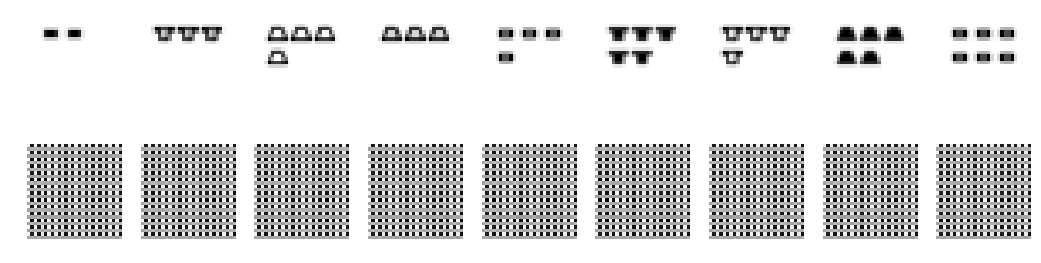

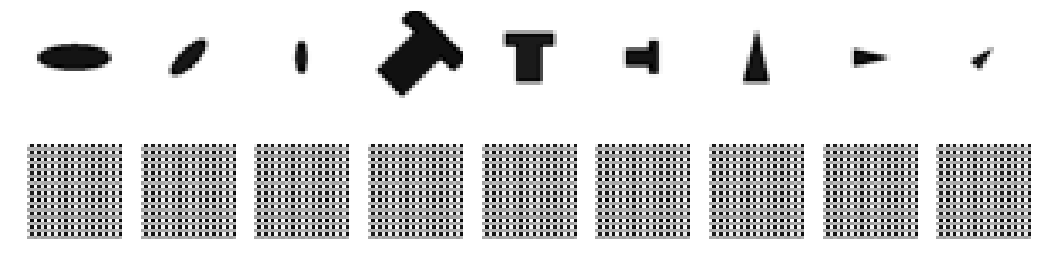

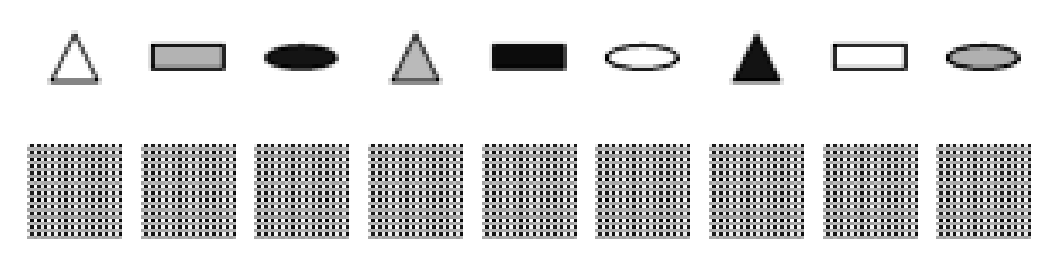

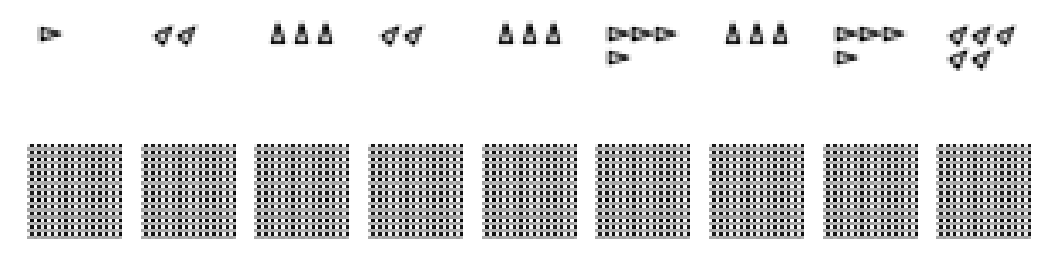

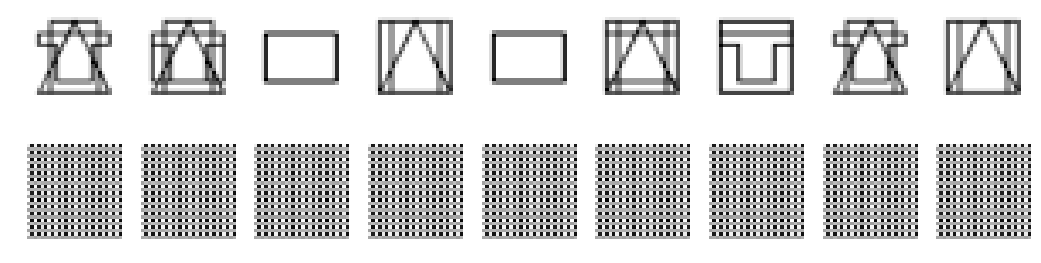

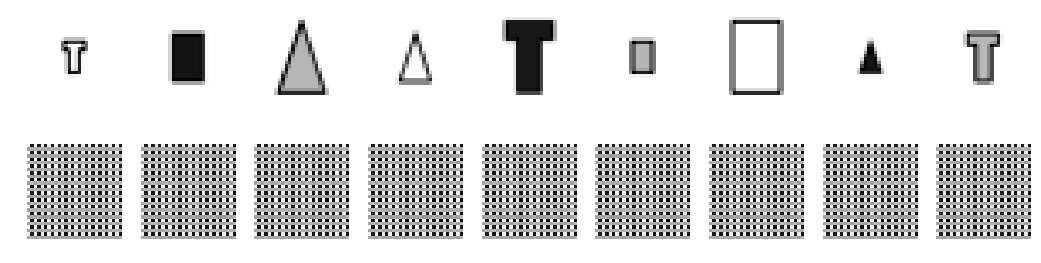

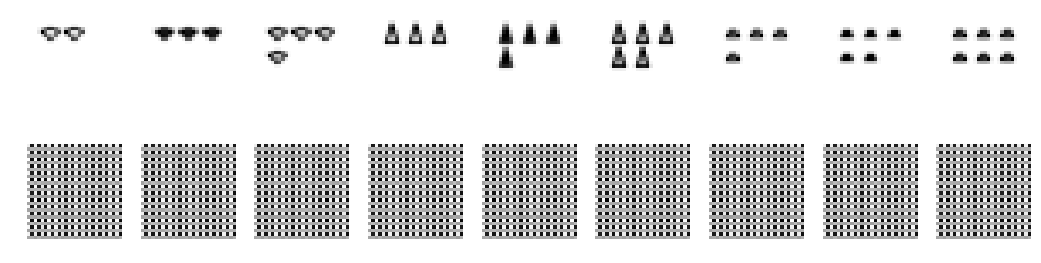

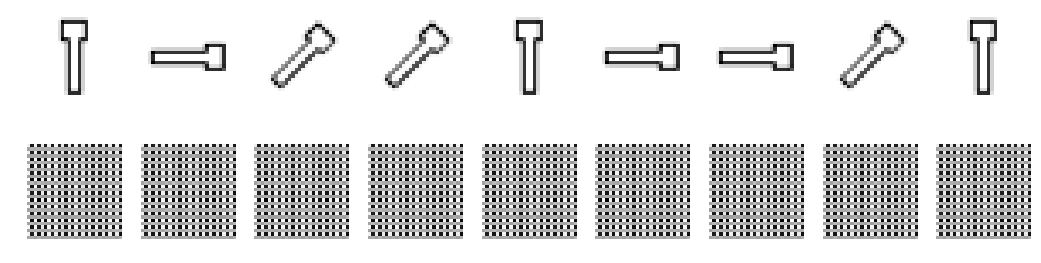

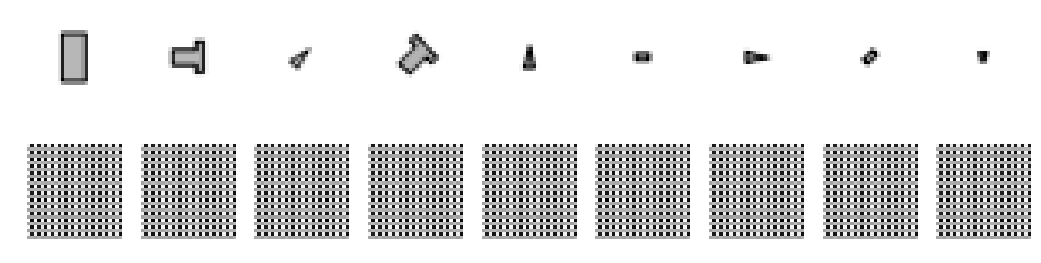

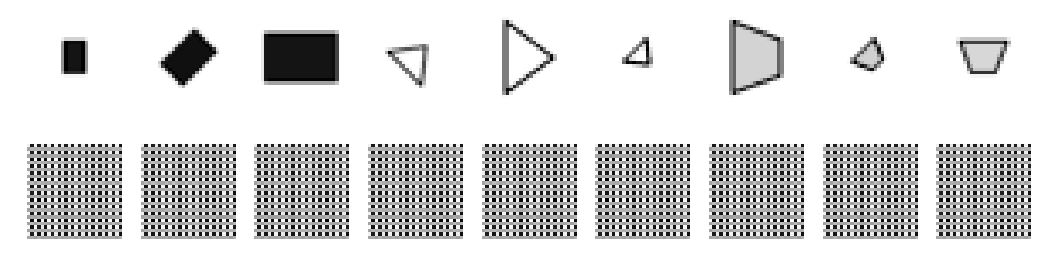

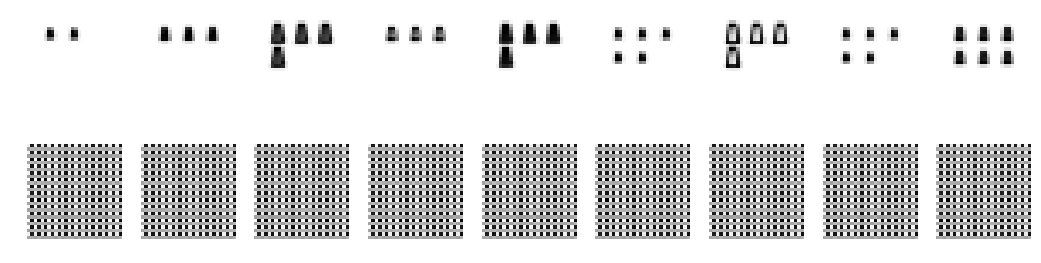

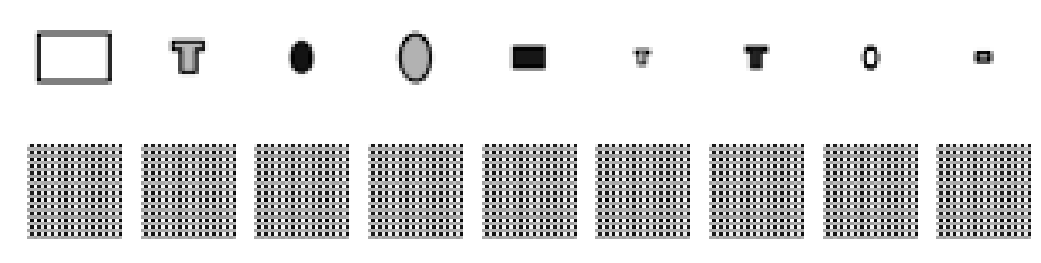

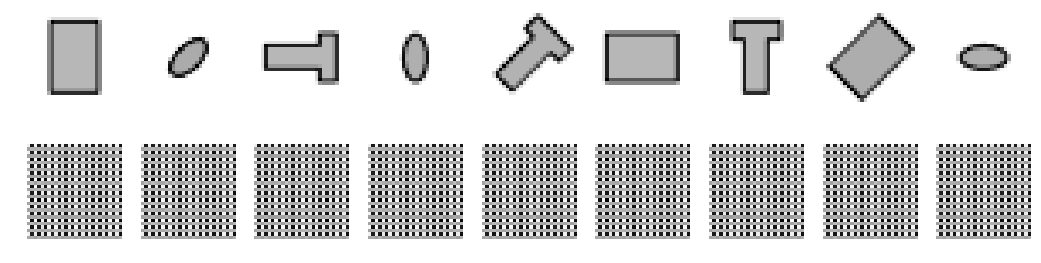

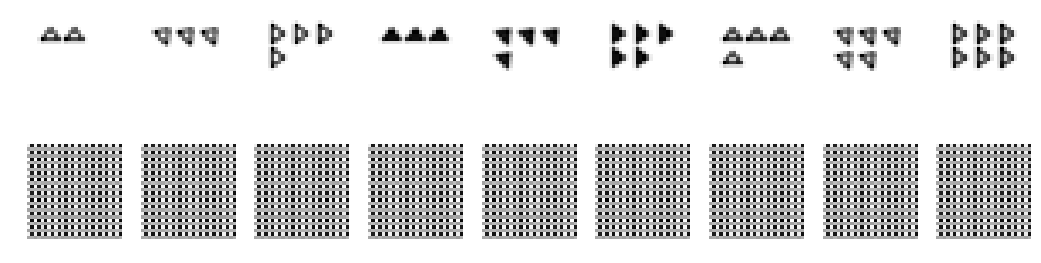

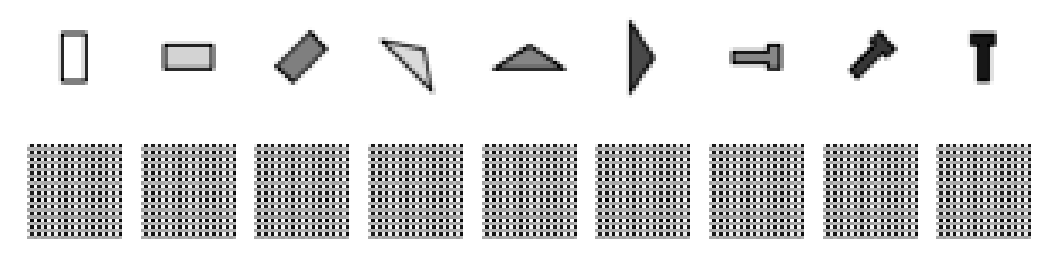

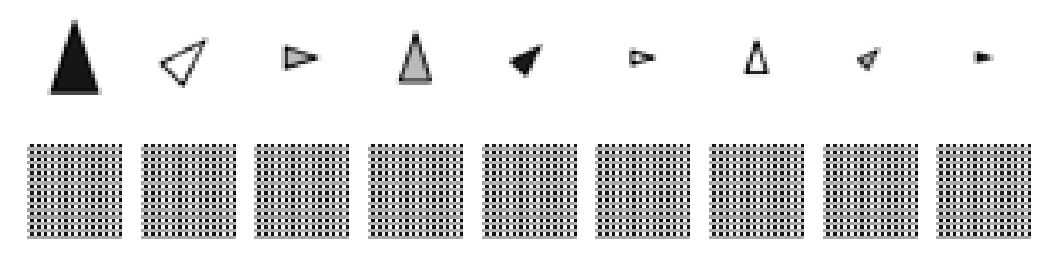

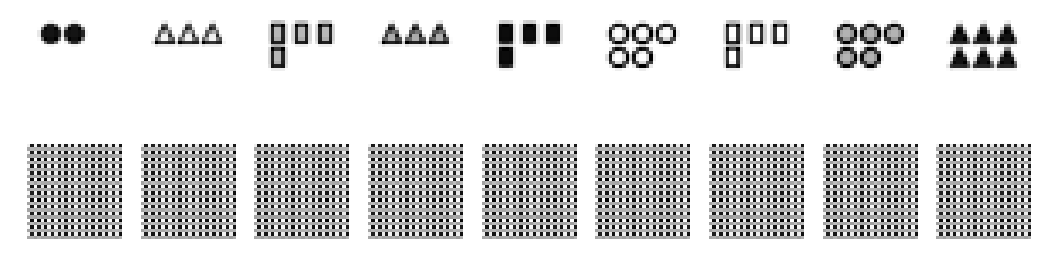

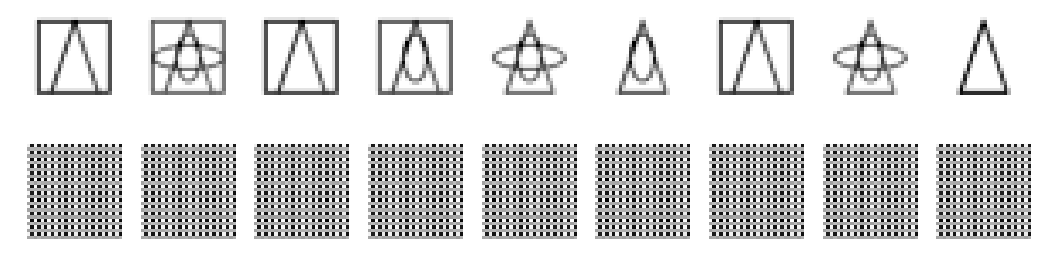

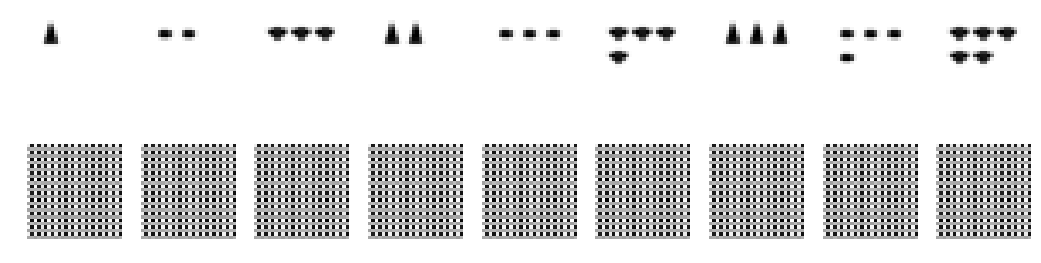

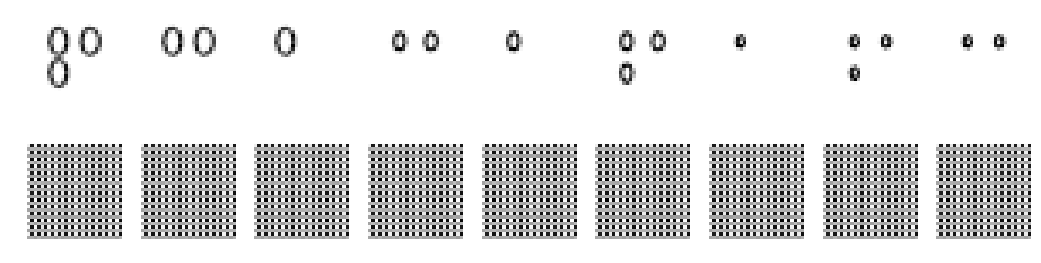

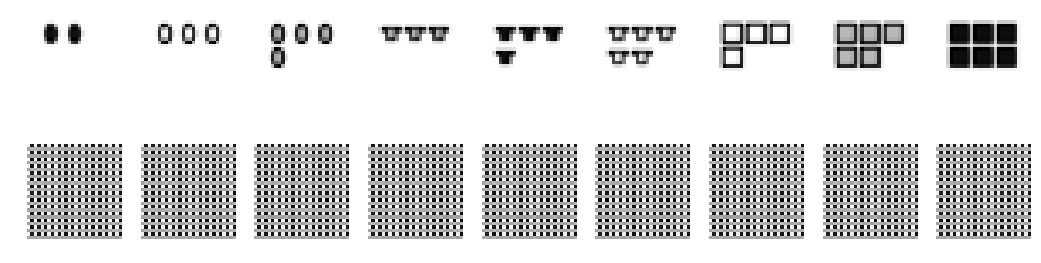

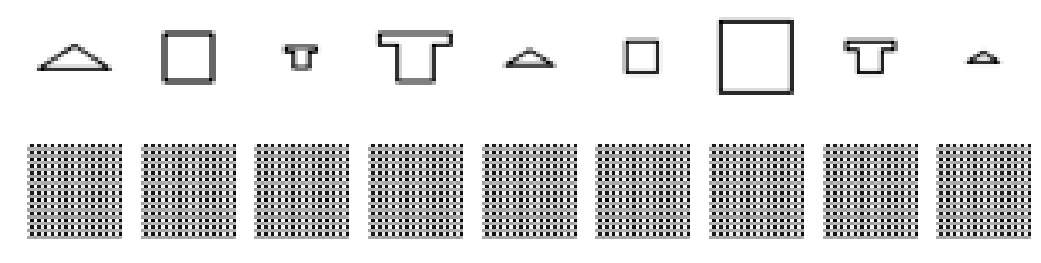

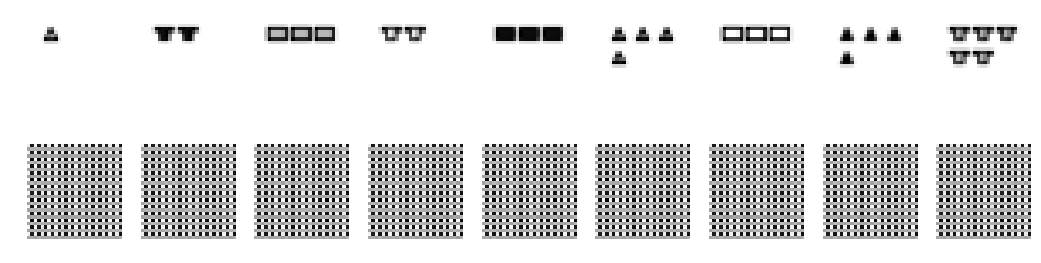

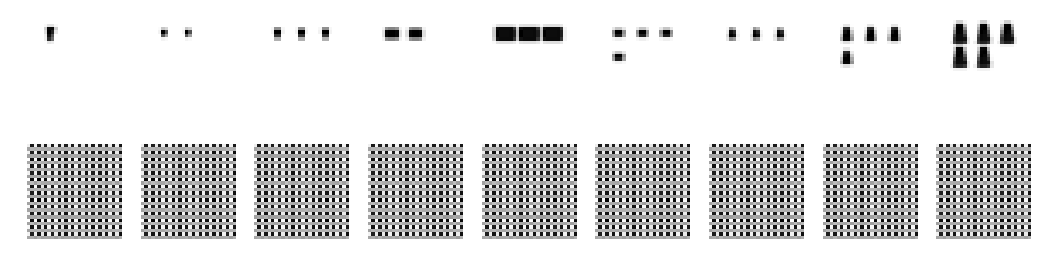

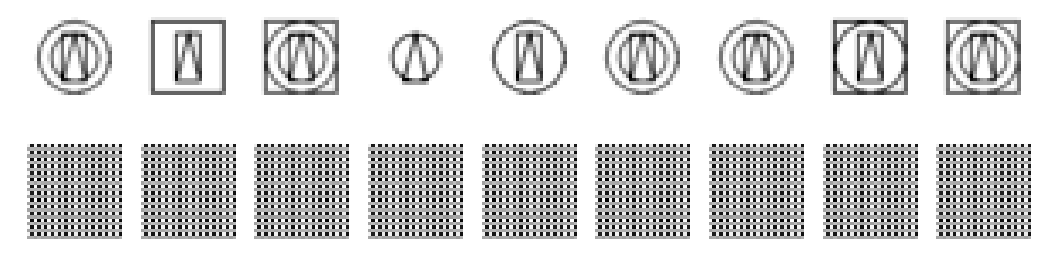

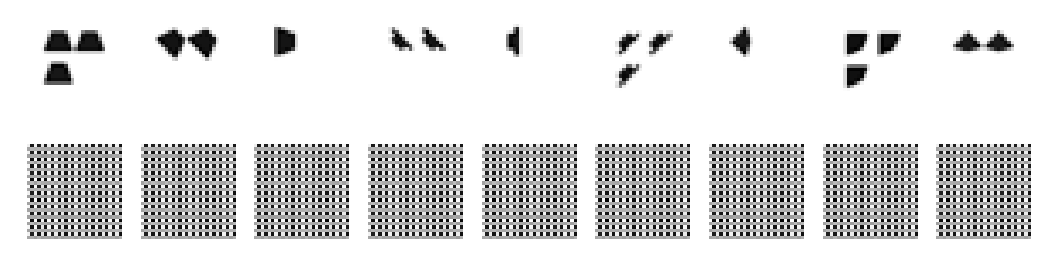

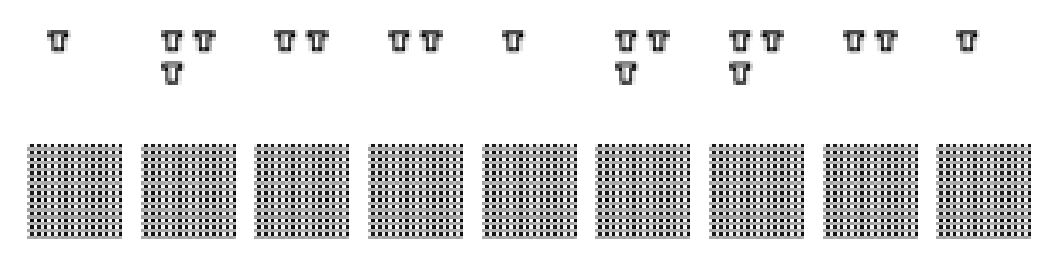

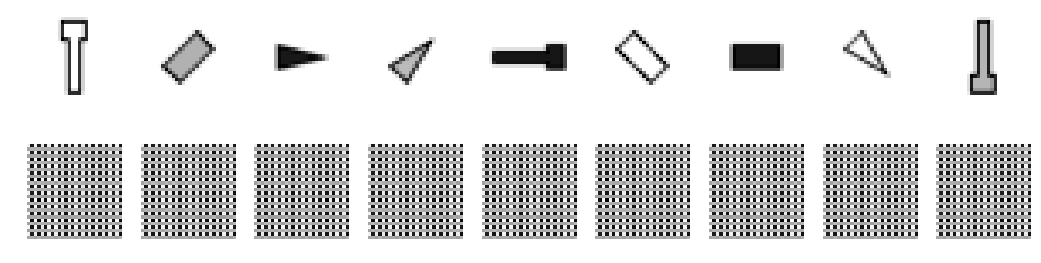

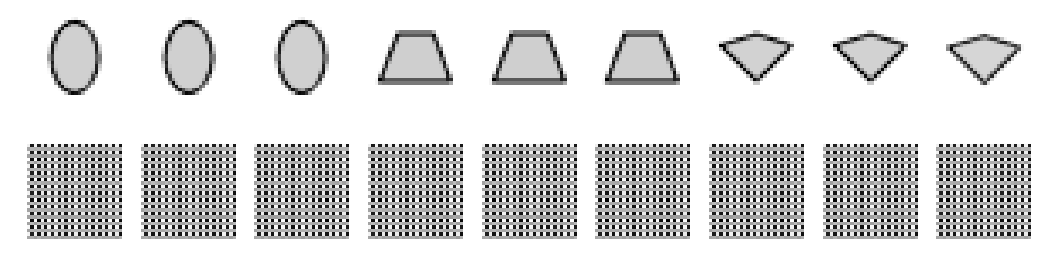

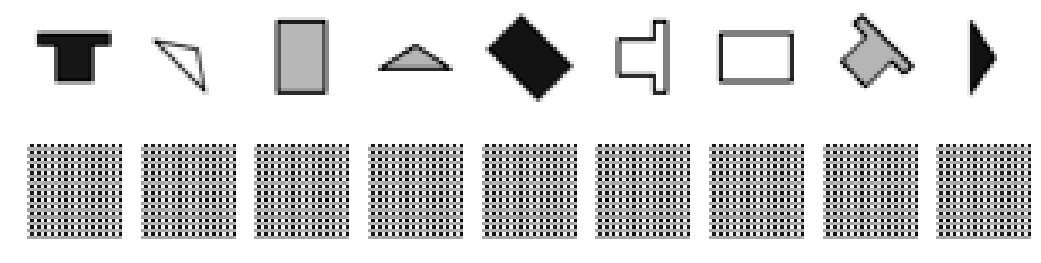

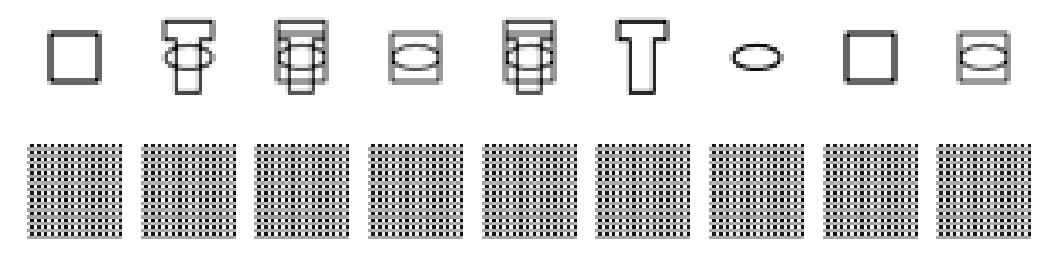

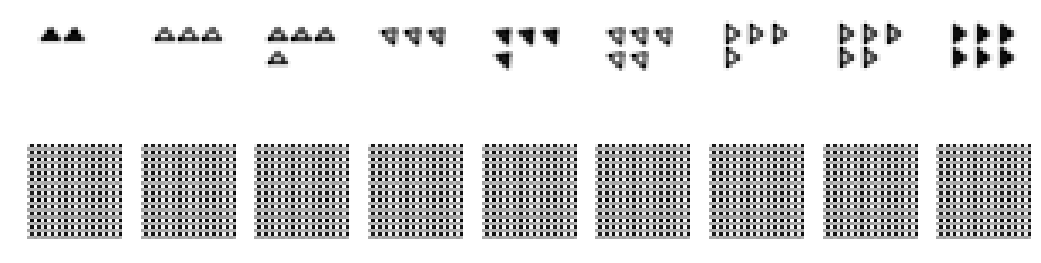

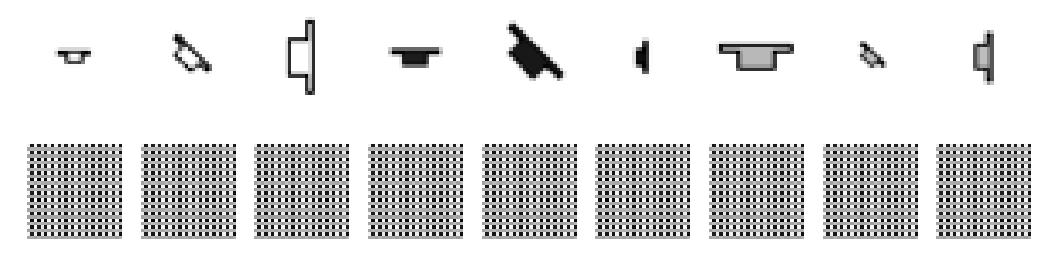

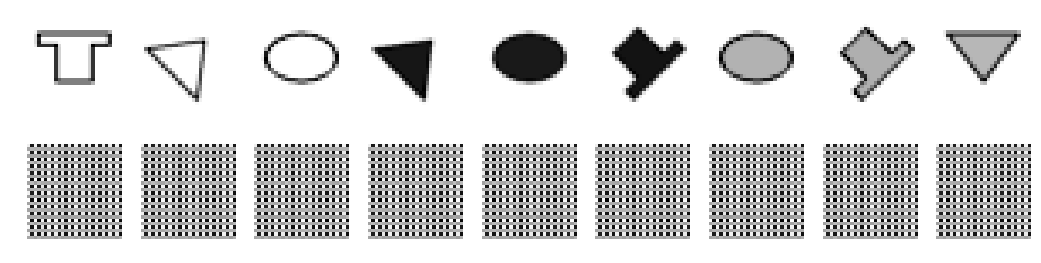

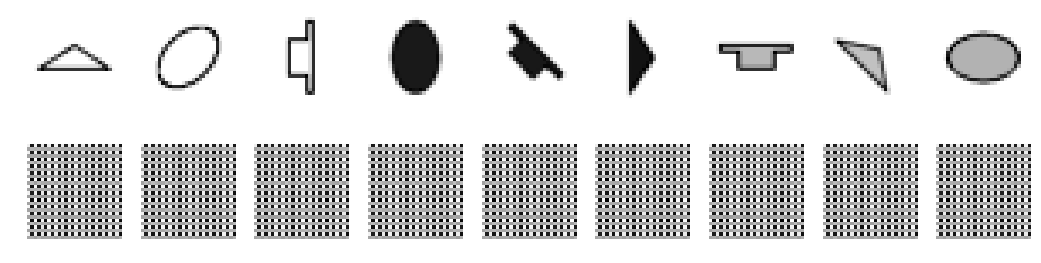

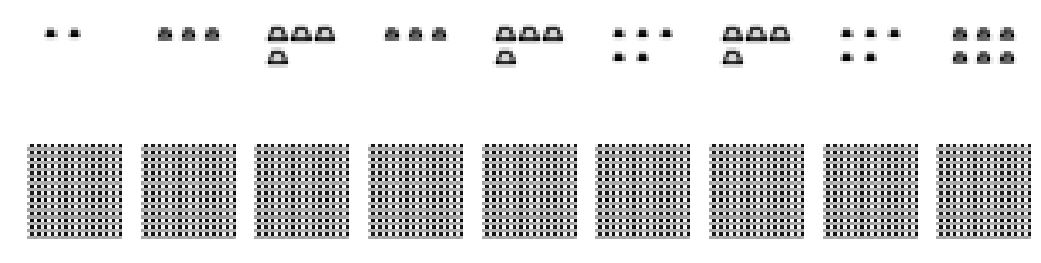

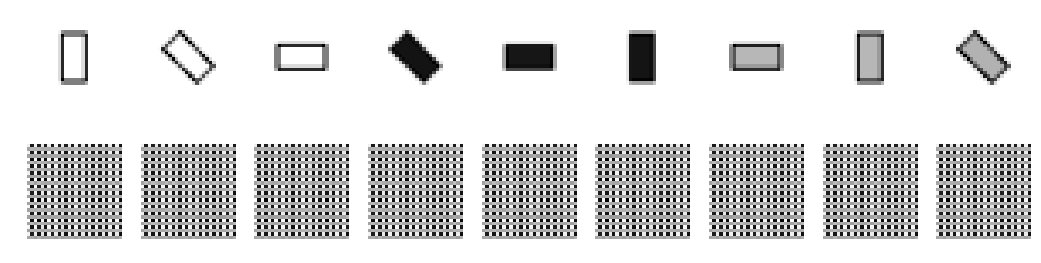

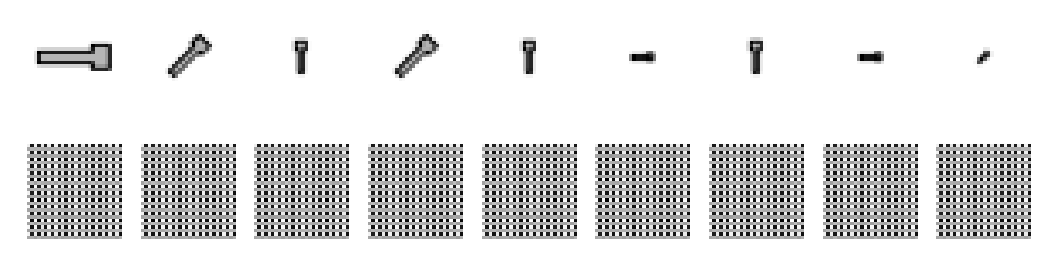

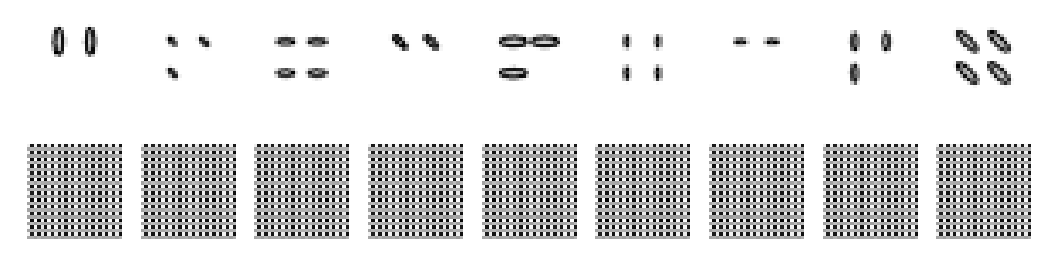

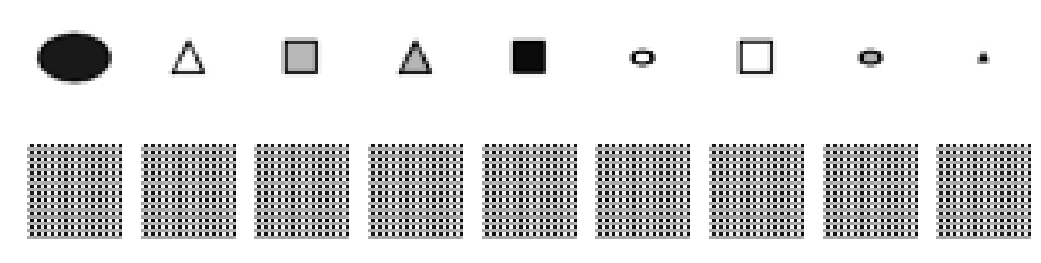

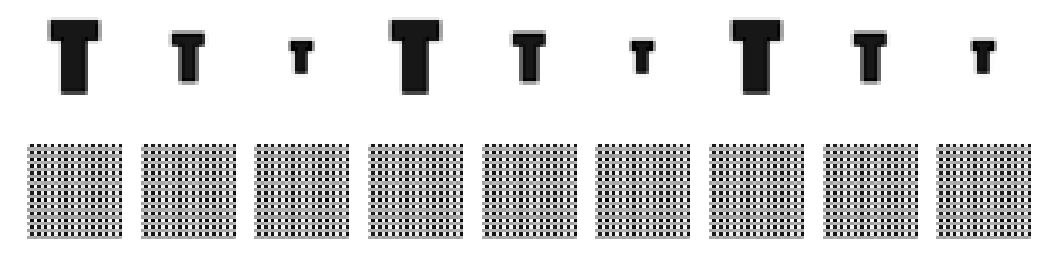

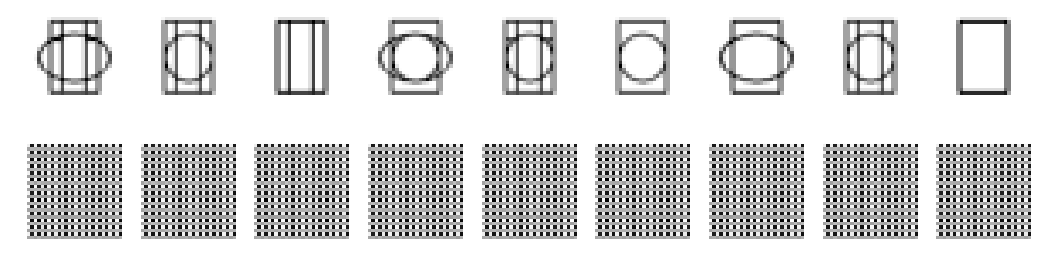

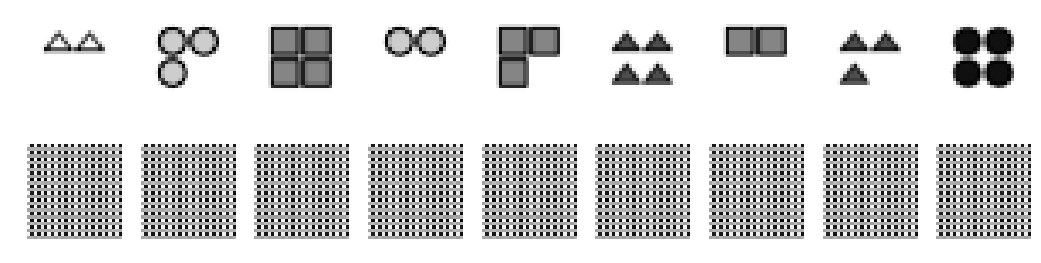

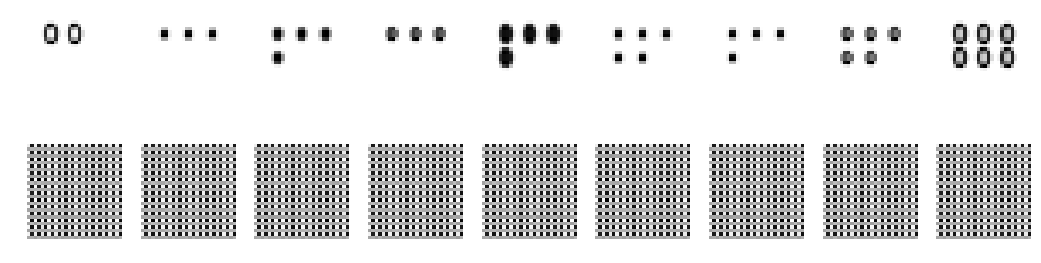

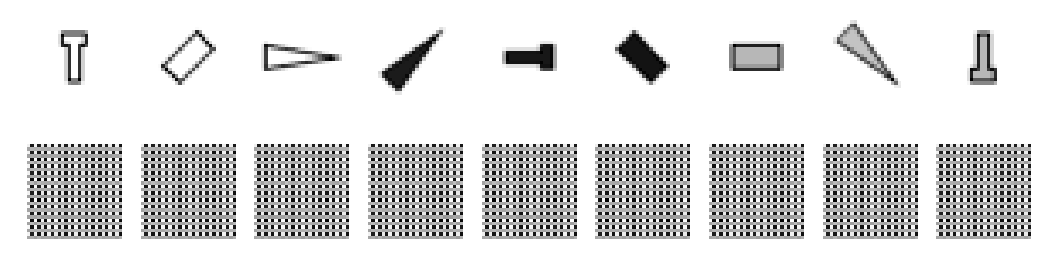

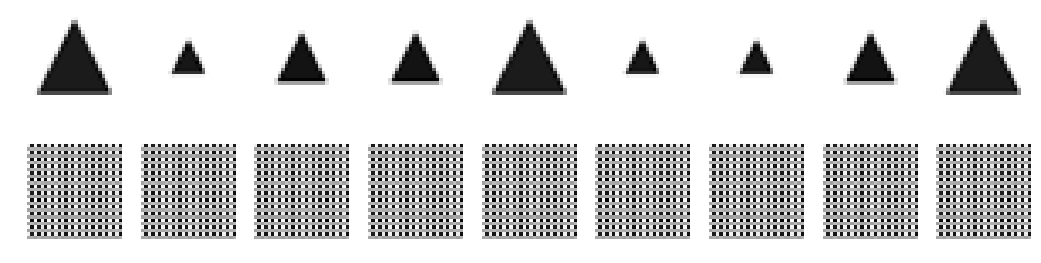

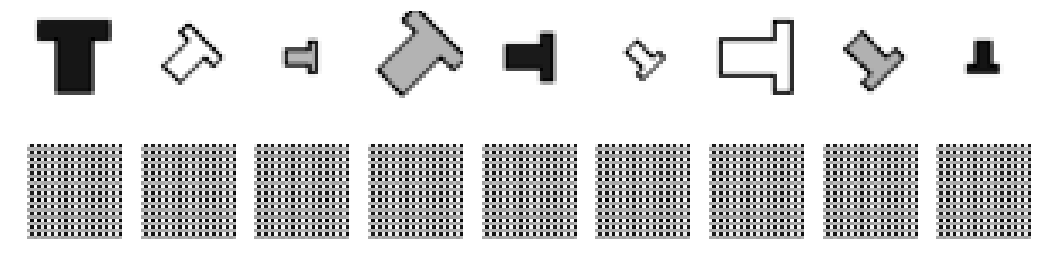

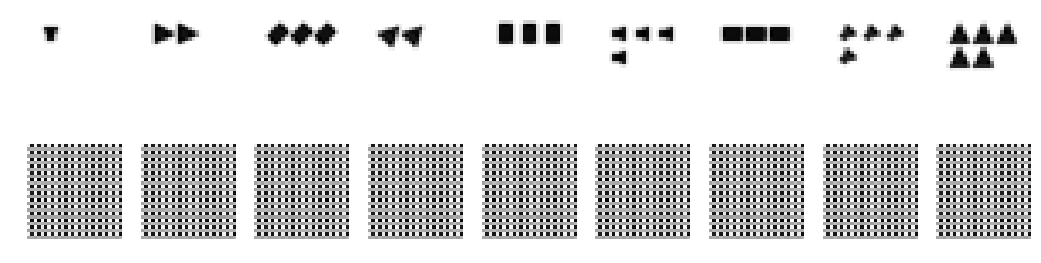

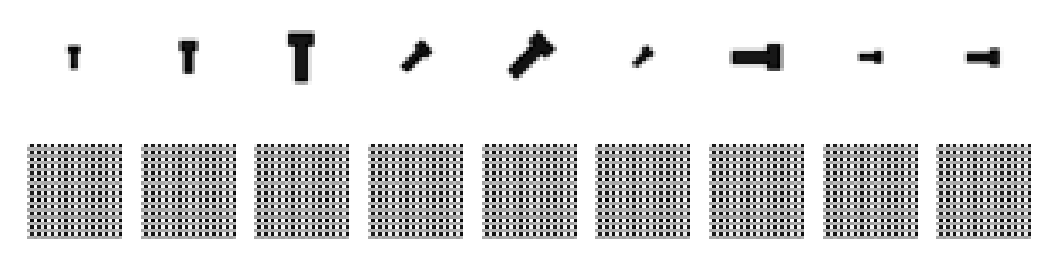

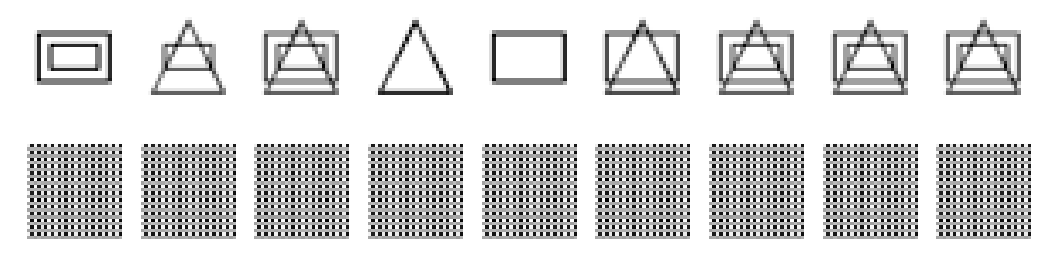

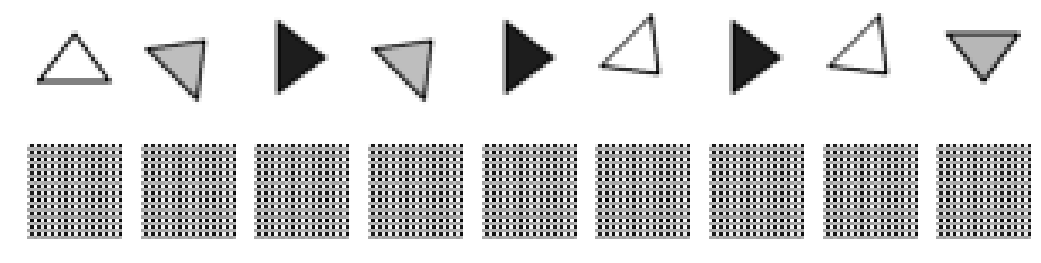

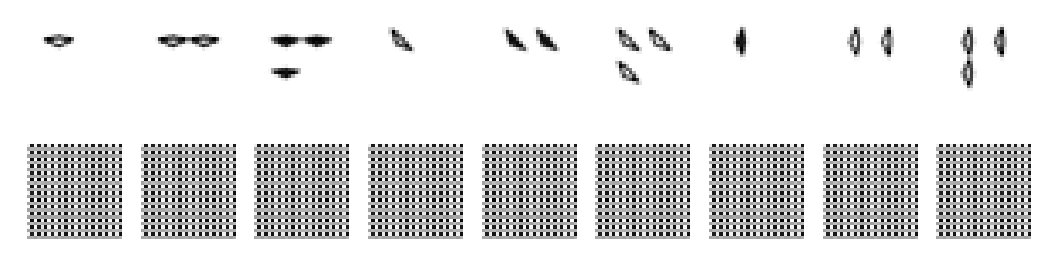

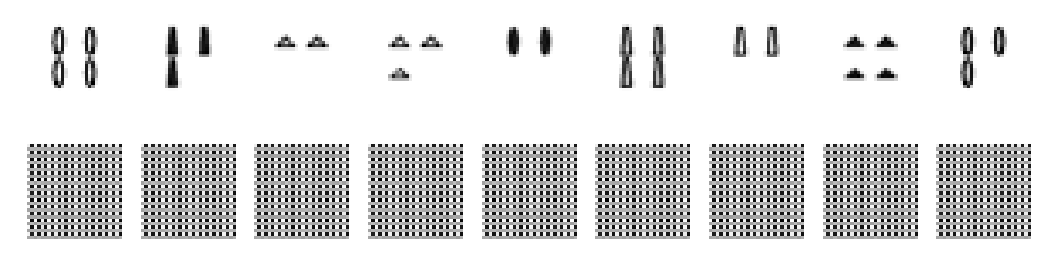

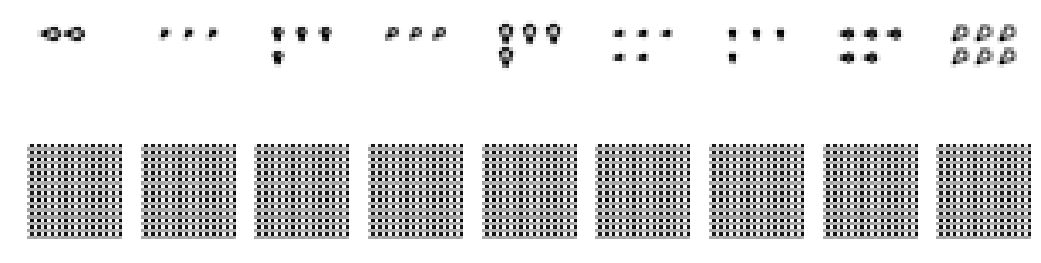

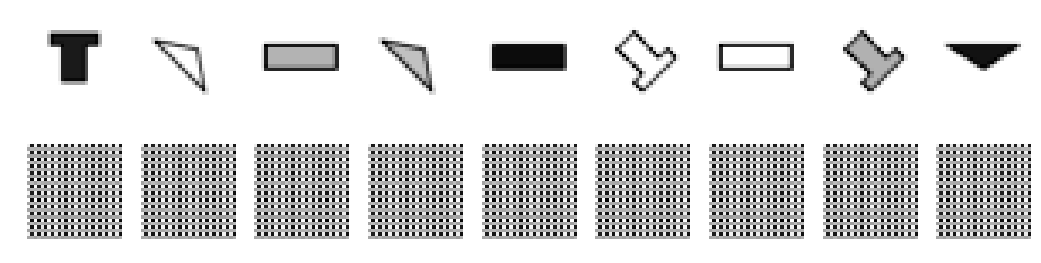

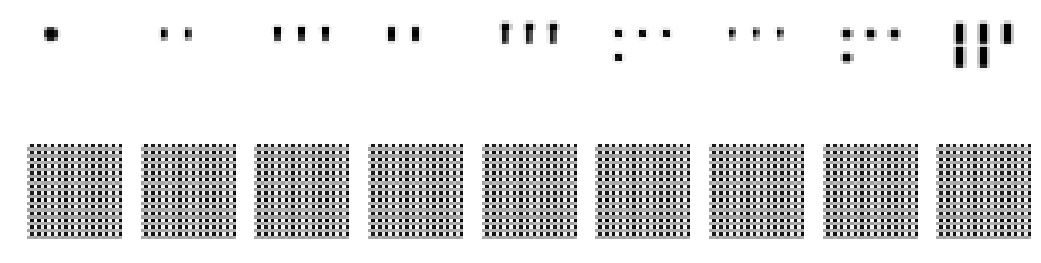

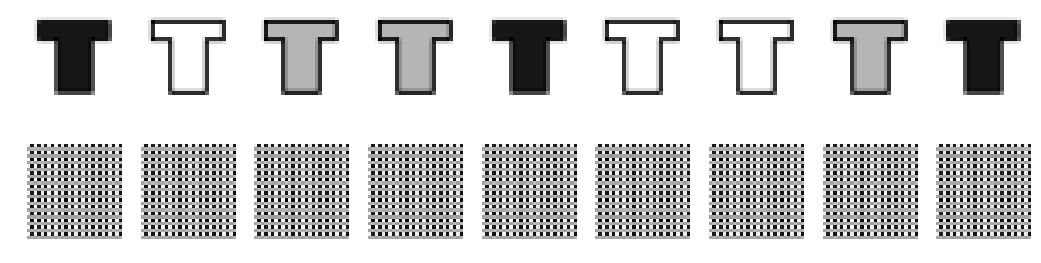

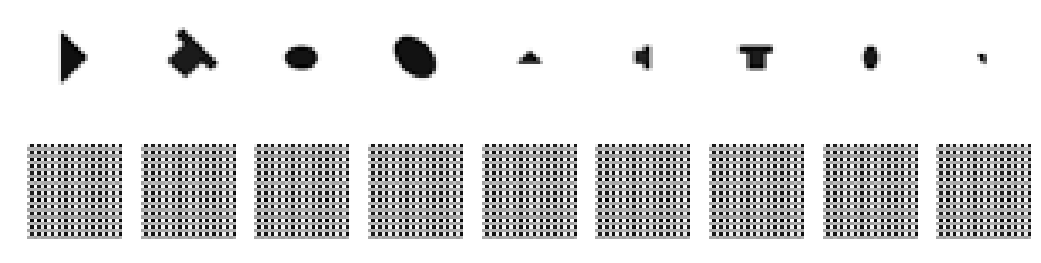

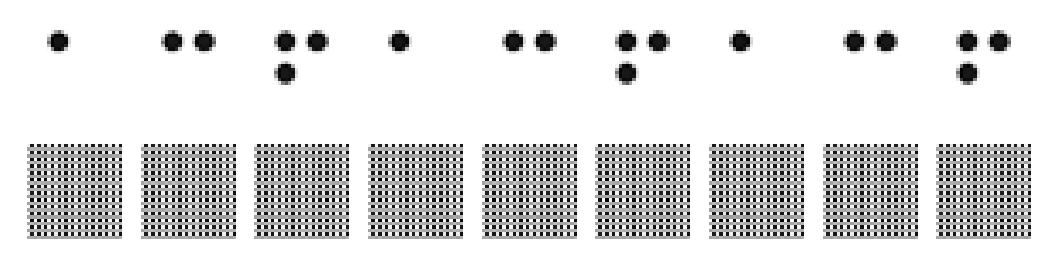

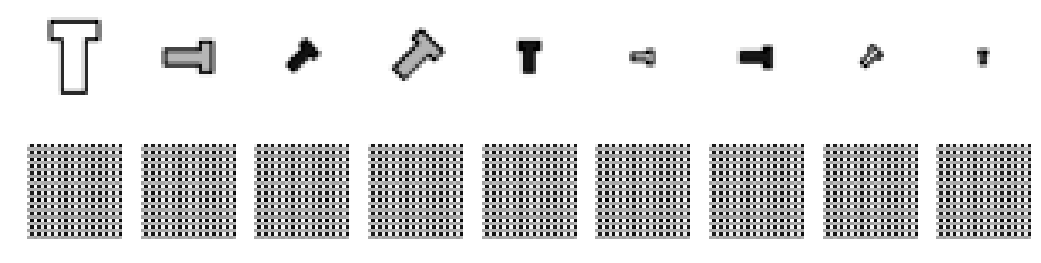

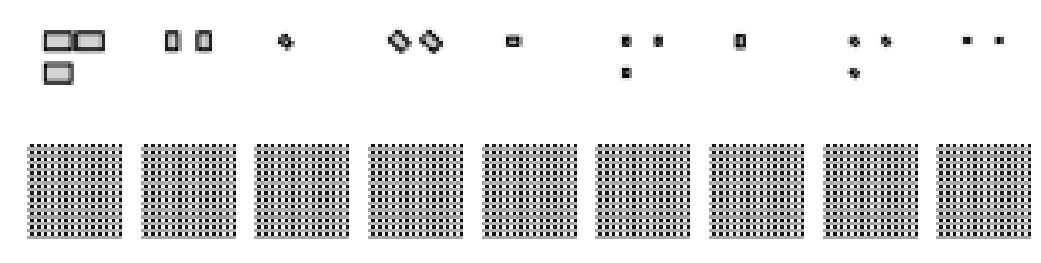

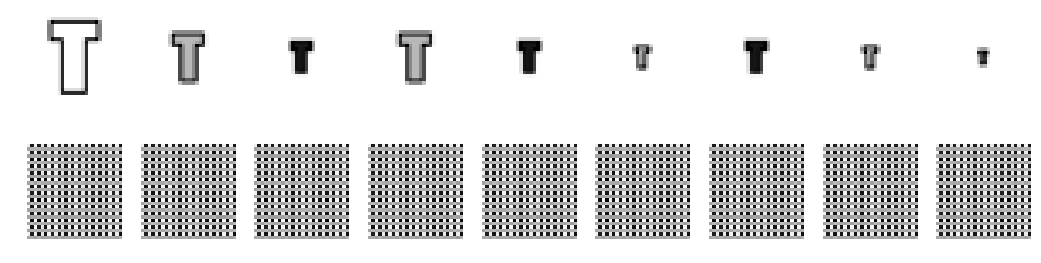

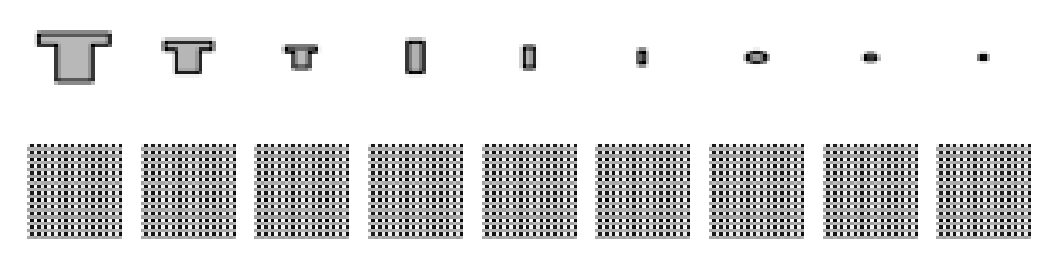

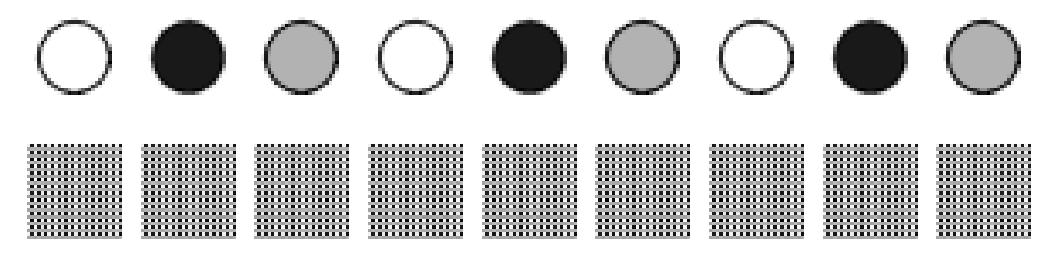

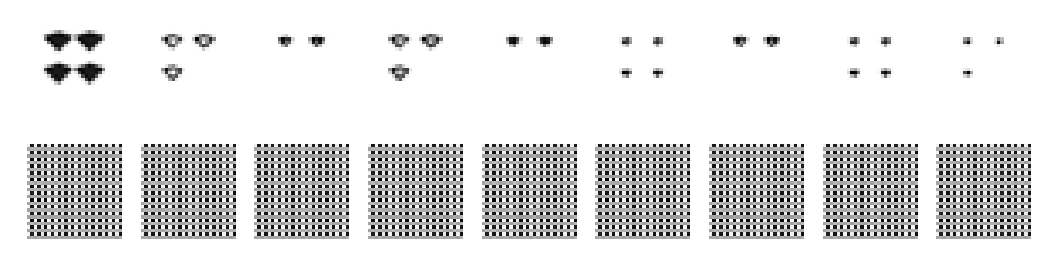

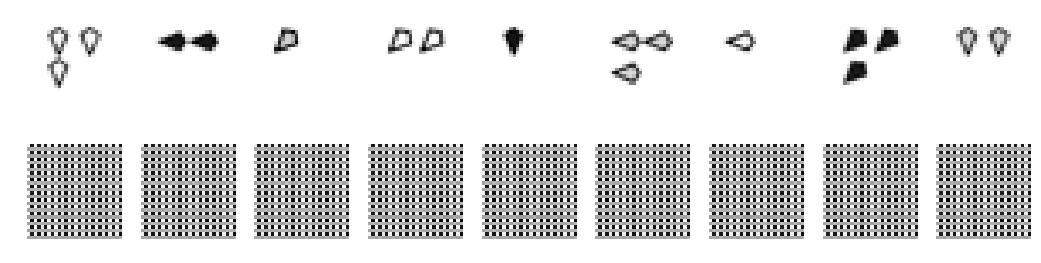

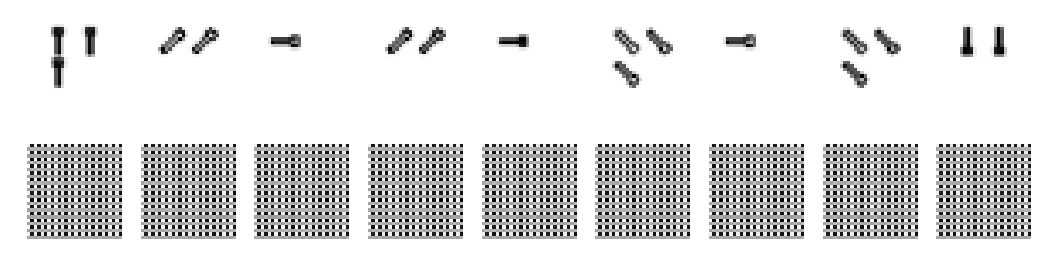

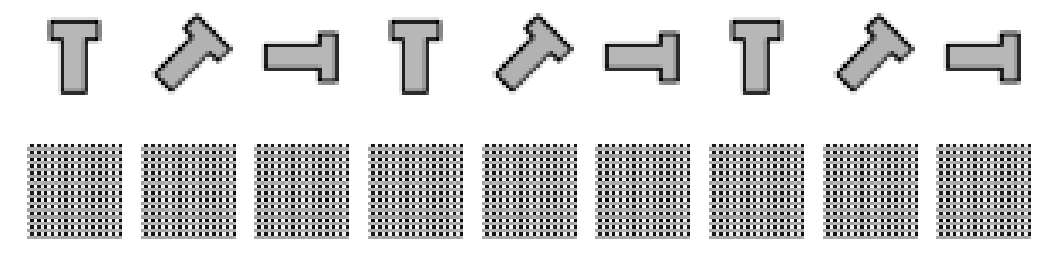

In [95]:
show_matrix(q_vectors, targets, decoded_q_vectors, decoded_prediction, cmap='gray')

### Compare with available answers

In [79]:
a_vectors_np = a_vectors.cpu().data.numpy()
decoded_prediction_np = decoded_prediction.cpu().data.numpy()

In [250]:
# Add border to correct
# Only use if axis border is broken
# for i in range(test_batch_size):
#     a_vectors_np[i][labels.data[i]][0, :] -= 1
#     a_vectors_np[i][labels.data[i]][-1, :] -= 1
#     a_vectors_np[i][labels.data[i]][:, 0] -= 1
#     a_vectors_np[i][labels.data[i]][:, -1] -= 1

In [67]:
pred, labels

(
  6
  6
  3
  4
  4
  6
  3
  2
 [torch.LongTensor of size 8], Variable containing:
  6
  6
  1
  0
  2
  6
  3
  2
 [torch.LongTensor of size 8])

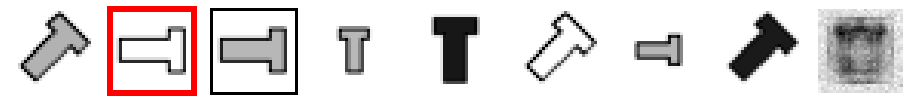

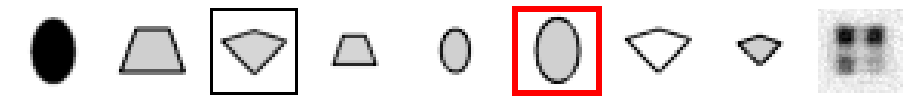

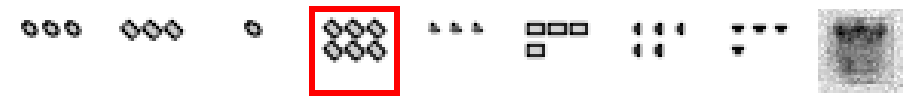

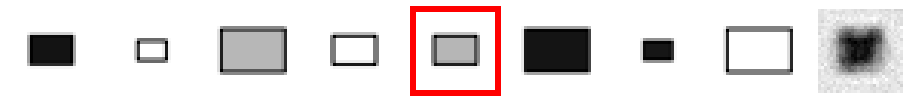

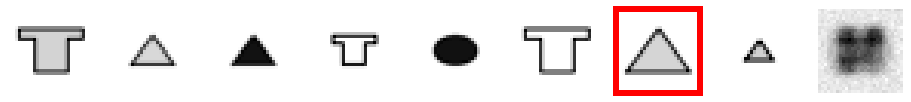

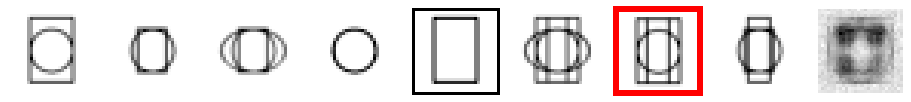

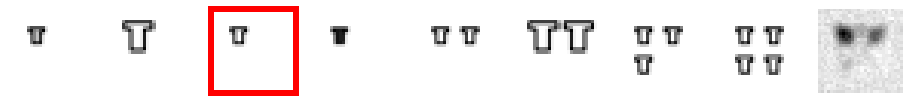

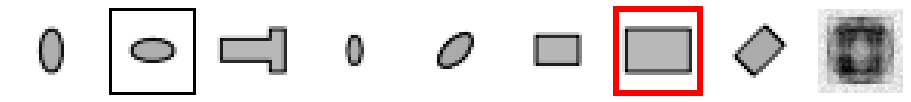

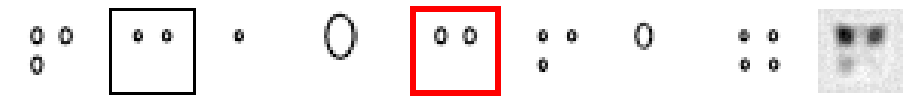

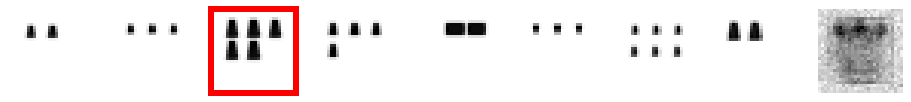

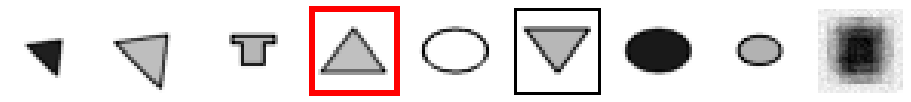

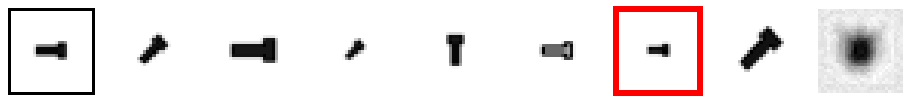

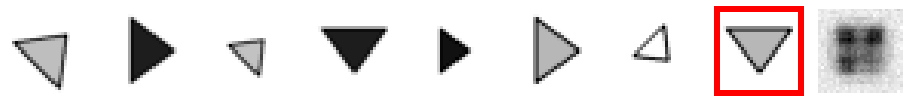

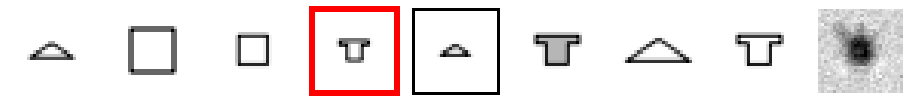

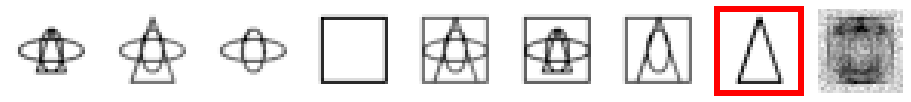

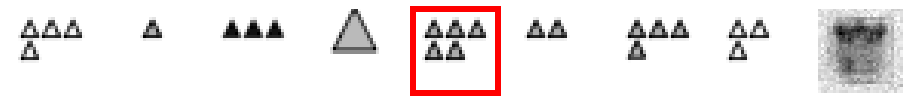

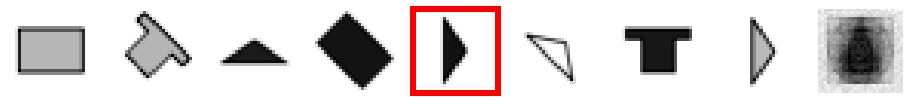

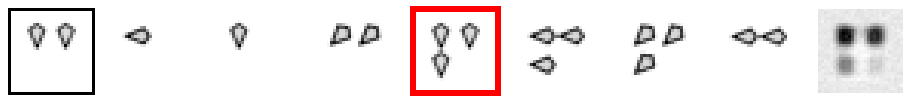

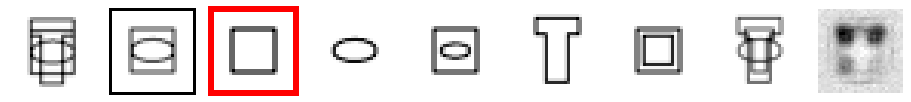

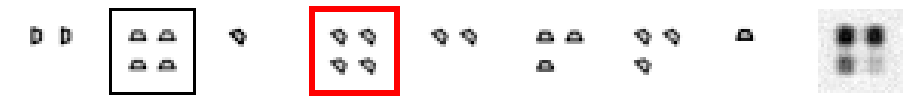

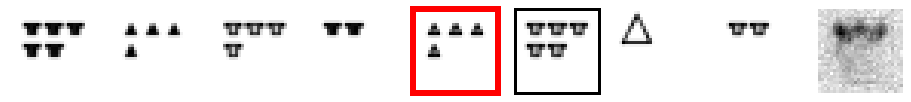

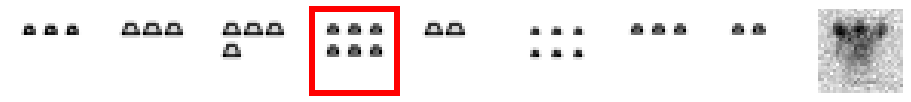

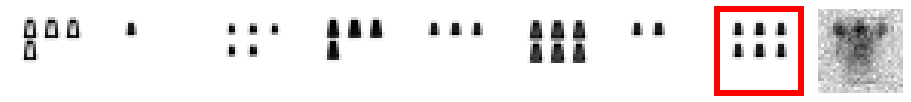

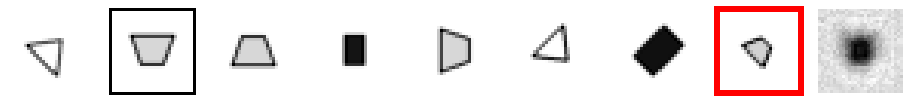

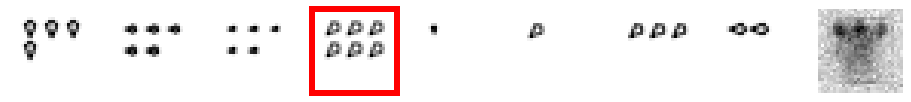

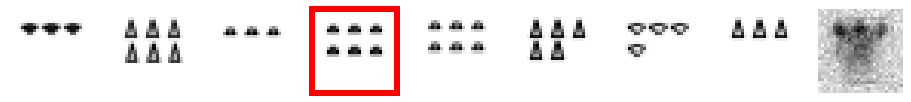

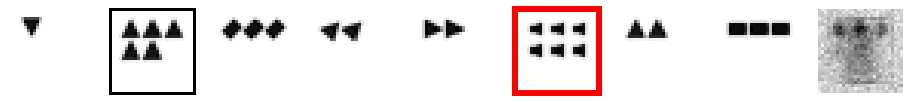

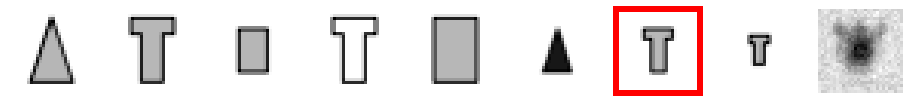

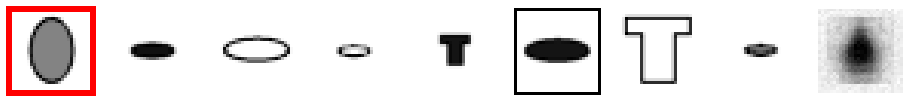

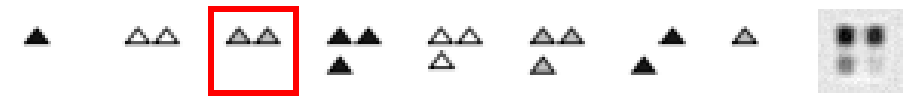

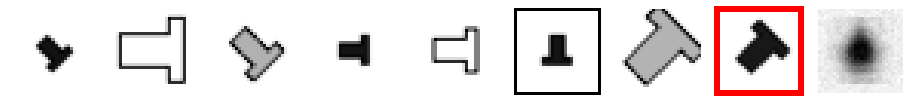

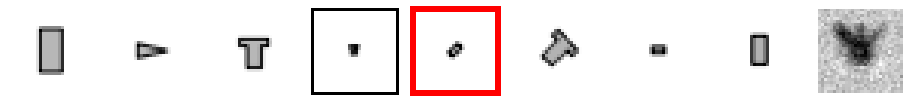

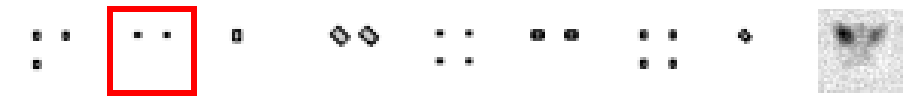

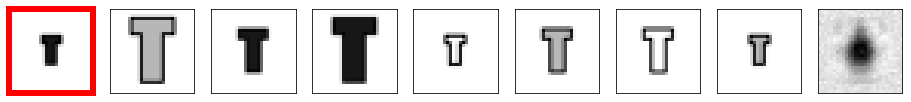

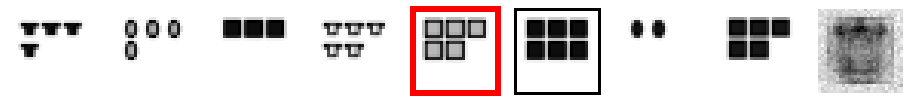

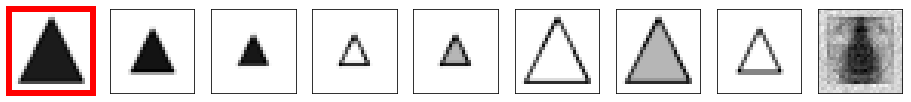

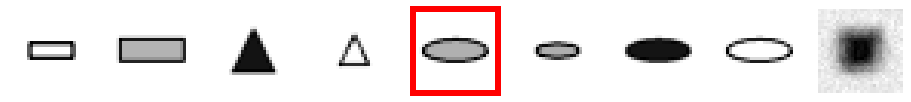

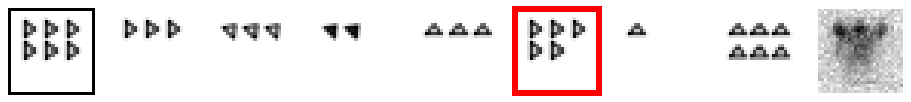

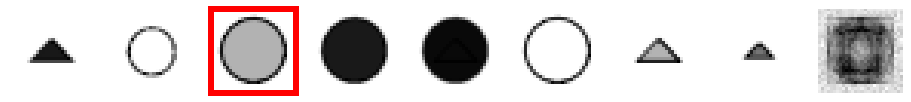

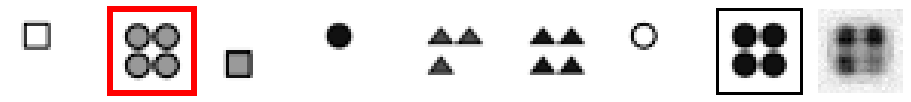

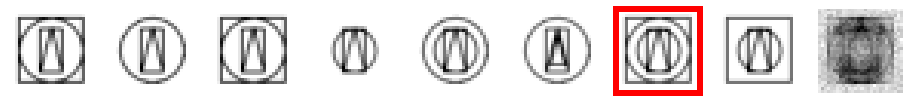

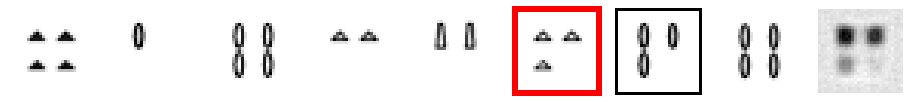

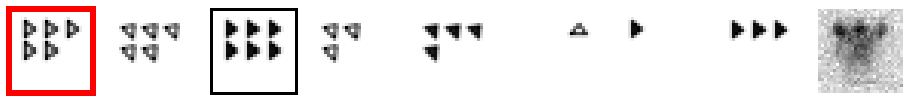

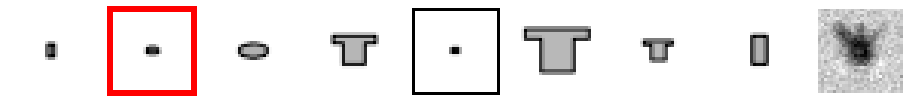

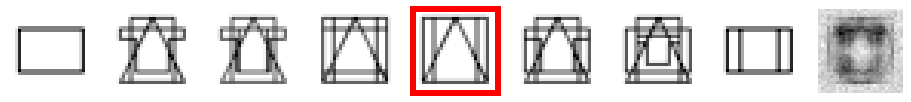

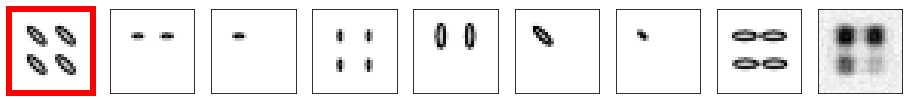

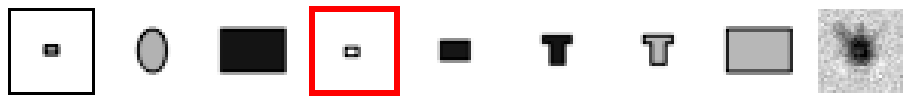

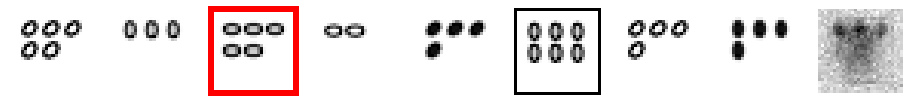

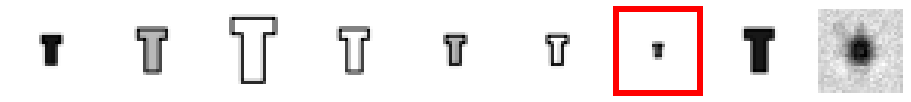

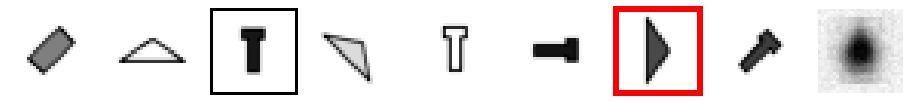

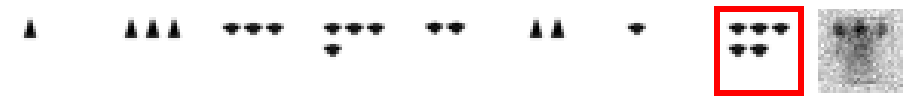

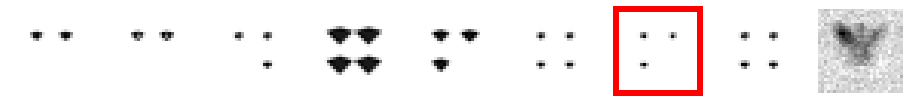

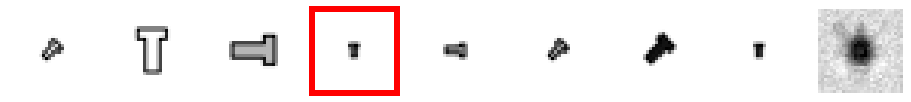

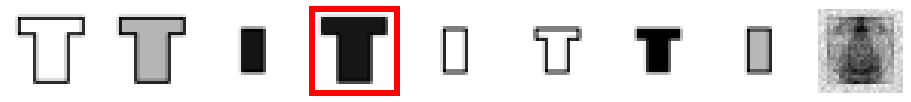

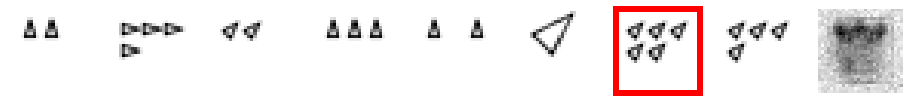

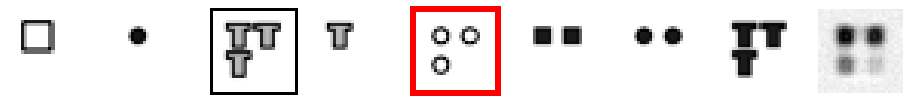

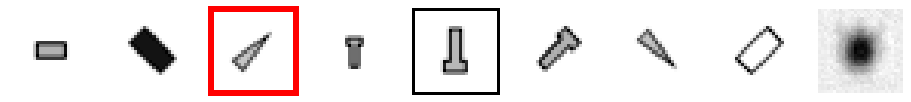

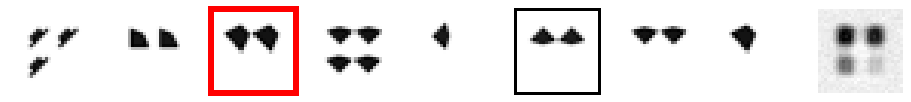

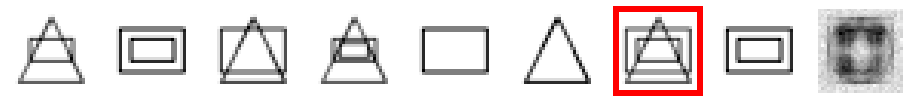

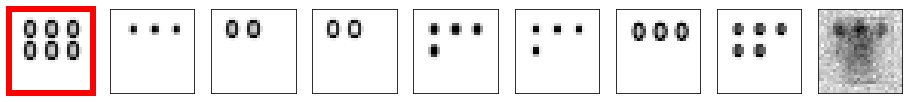

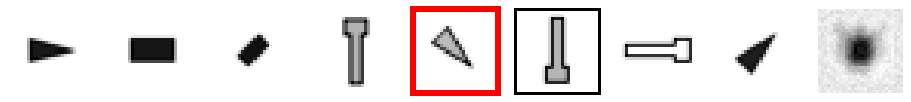

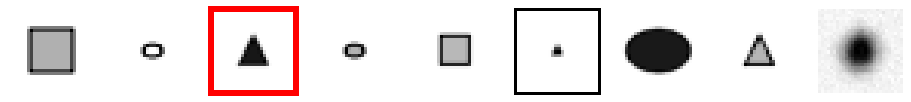

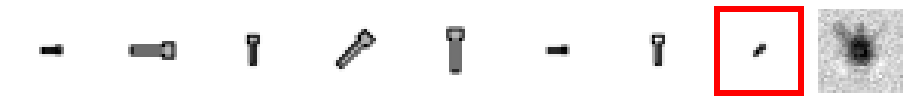

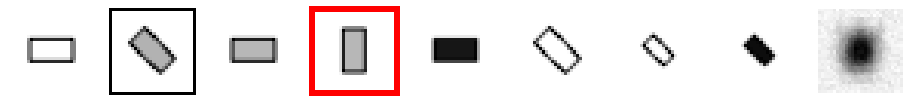

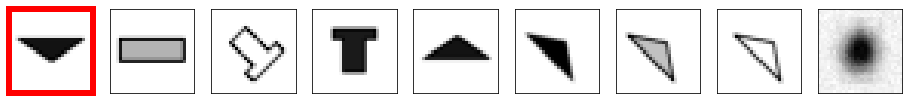

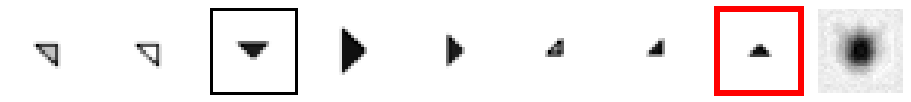

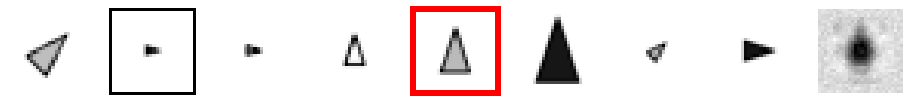

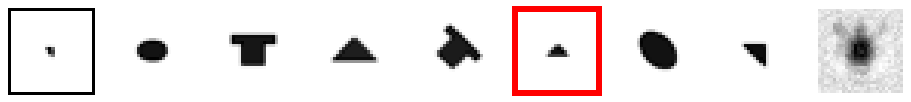

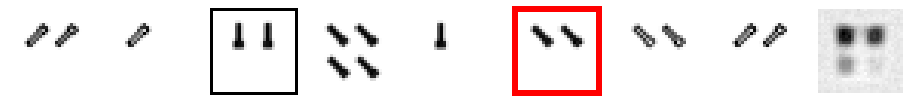

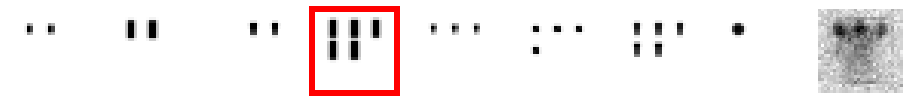

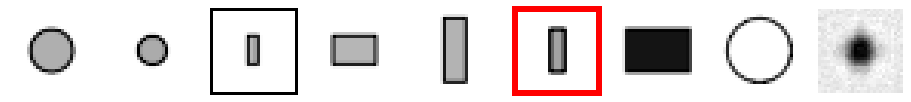

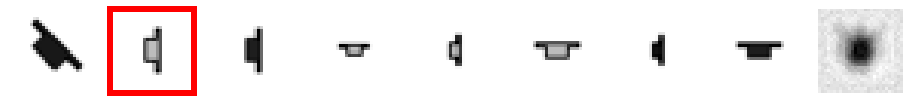

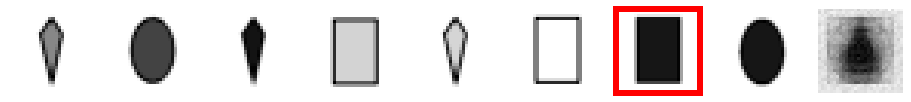

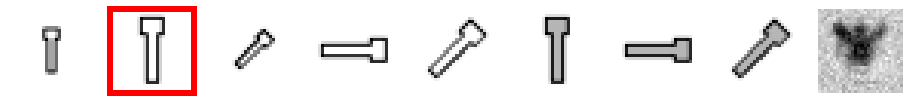

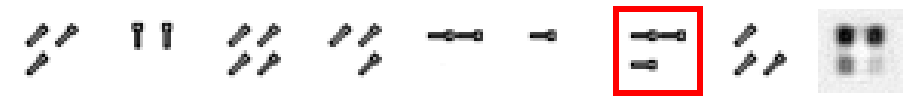

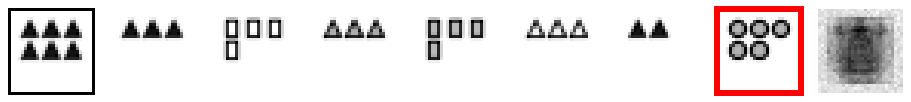

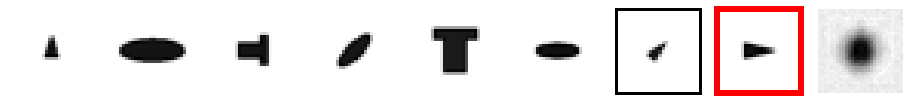

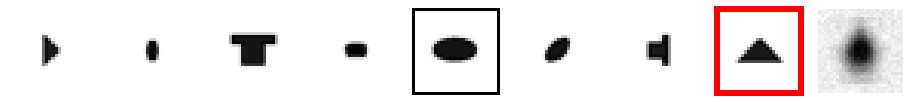

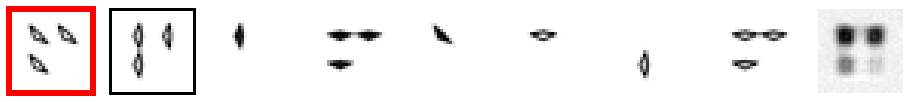

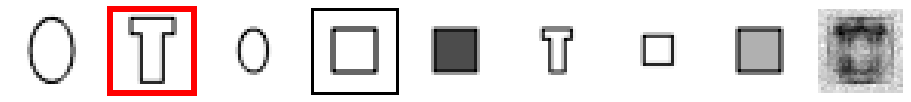

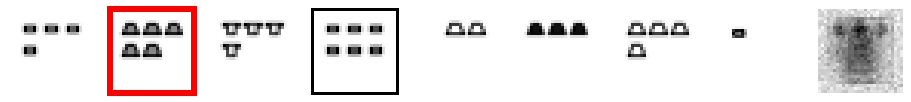

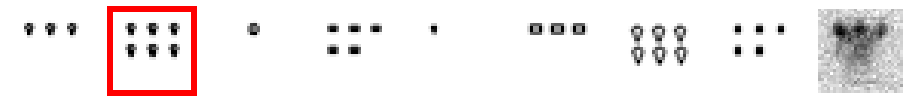

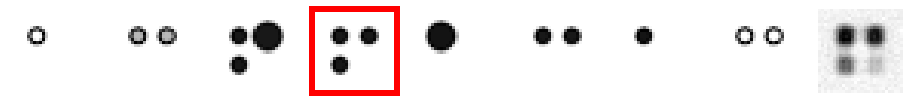

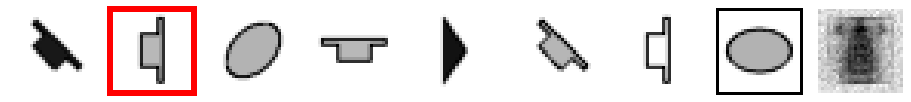

In [80]:
from src.utils import show_grid_of_images

for i in range(val_batch_size):
    show_grid_of_images(np.concatenate([a_vectors_np[i], decoded_prediction_np[i:i+1]]), img_size=(16, 1), grid_size=(1, 9), label=labels[i].cpu().data.numpy(), pred=pred_var[i].cpu().data.numpy(), cmap='gray')